# CS909/CS429 2023 Assignment 1: Classification

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import csv

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, \
    roc_curve, precision_recall_curve, auc, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy import ndimage

## Question No. 1: Exploring data

*Start by loading the training and test data.*

In [3]:
# Load training data
Xtrain = np.loadtxt('Xtrain.csv')

# Load training labels
Ytrain = np.loadtxt('Ytrain.csv')

# Load test data
Xtest = np.loadtxt('Xtest.csv')

### i. Dataset Overview

*a. How many examples are in the training set? And in the test set?*

In [3]:
# Number of examples in the training and test set
num_examples_train = Xtrain.shape[0]
num_examples_test = Xtest.shape[0]

print("Number of examples in the training set:", num_examples_train)
print("Number of examples in the test set:", num_examples_test)

Number of examples in the training set: 3000
Number of examples in the test set: 3000


*b. Within the training data, count the positive and negative examples. What's the distribution like? Does this distribution signify any potential issues in terms of design of the machine learning solution and its evaluation?*

In [4]:
# Count positive examples
num_positive = np.sum(Ytrain == 1)

# Count negative examples
num_negative = np.sum(Ytrain == -1)

print("Number of positive examples in the training data:", num_positive)
print("Number of negative examples in the training data:", num_negative)

Number of positive examples in the training data: 311
Number of negative examples in the training data: 2689


This is an imbalanced dataset where the negative examples significantly outnumber the positive examples. The class imbalance can potentially lead to challenges in training a machine learning model, here are some considerations:

1. **Model Bias**: The imbalanced class distribution may cause the model to be biased towards the majority (negative) class. High accuracy may be achieved by simply predicting the majority class, but performance on the minority class may be poor.

2. **Evaluation Metrics**: Accuracy may not be a suitable evaluation metric in imbalanced datasets. It's important to look at precision, recall, etc, which take into account both true positives and false positives.

3. **Handling Imbalance**: Consider using techniques to handle class imbalance, such as oversampling the minority class, undersampling the majority class, or using algorithms that assign class weight to handle imbalanced datasets.

4. **Cross-Validation Issues**: When evaluating the model, consider using techniques like stratified cross-validation to ensure that each fold maintains a similar class distribution.

5. **Monitoring Training**: Keep an eye on the model's performance on both classes during training. If the model struggles to learn the minority class, it might be necessary to adjust the training strategy.

### ii. Visual Data Exploration

*a. Pick 10 random objects from each class in the training data and display them using plt.matshow. Reshape the flattened 28x28 arrays for this. What patterns or characteristics do you notice?*

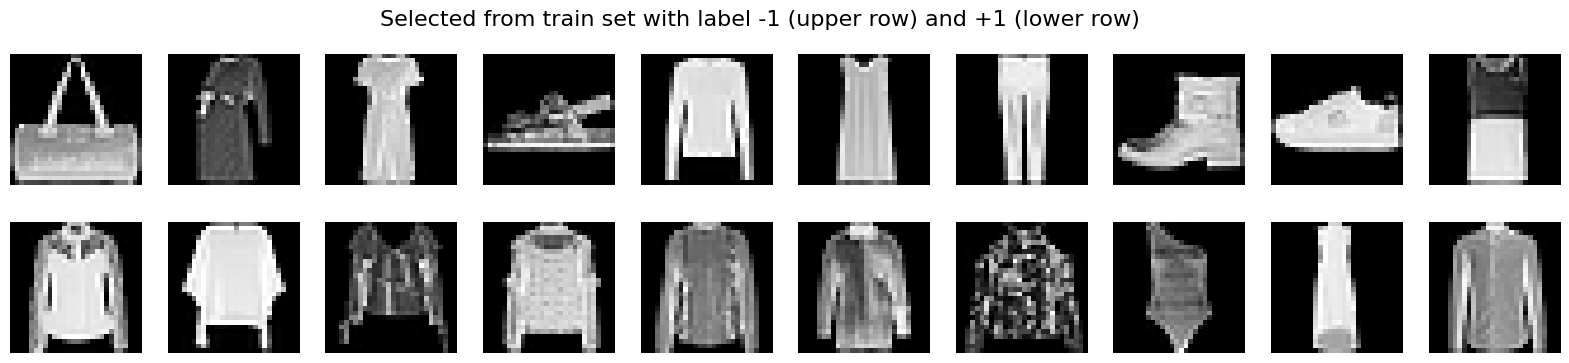

In [7]:
num_classes = 2
class_labels = [-1, 1]

# Create a figure for plotting
fig, axes = plt.subplots(num_classes, 10, figsize=(20, 4))

# Iterate through each class
for i in range(num_classes):
    # Select 10 random objects from each class
    class_indices = np.where(Ytrain == class_labels[i])[0]
    random_indices = np.random.choice(class_indices, size=10, replace=False)
    random_objects = Xtrain[random_indices]

    # Reshape and display the flattened 28x28 arrays
    for j in range(10):
        axes[i, j].matshow(random_objects[j].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from train set with label -1 (upper row) and +1 (lower row)', fontsize=16)

plt.show()

Based on the observations of the randomly selected images from the training set, some patterns are noteworthy:

1. **Diversity in Label -1**: The class labeled as -1 appears to encompass a variety of items such as tops, pants, long garments, shoes, and bags. This suggests a diverse range of objects falling under this class.

2. **Consistency in Label 1**: The class labeled as 1 is more consistent, predominantly representing tops or upper garments.

3. **Potential Labeling Inconsistency**: There is a potential concern about the accuracy or criteria of labeling within the -1 class. The presence of various items within this class, including both upper/lower garments and other accessories, raises questions about the consistency and precision of labeling.

4. **Further Analysis**: A more in-depth analysis of the samples labeled as -1 is recommended. Examining the -1 class samples and assessing their distribution within the training set may provide additional insights into potential labeling issues.

*b. Do the same for 10 random objects from the test set. Are there any peculiarities in the data that might challenge your classifier's ability to generalise?*

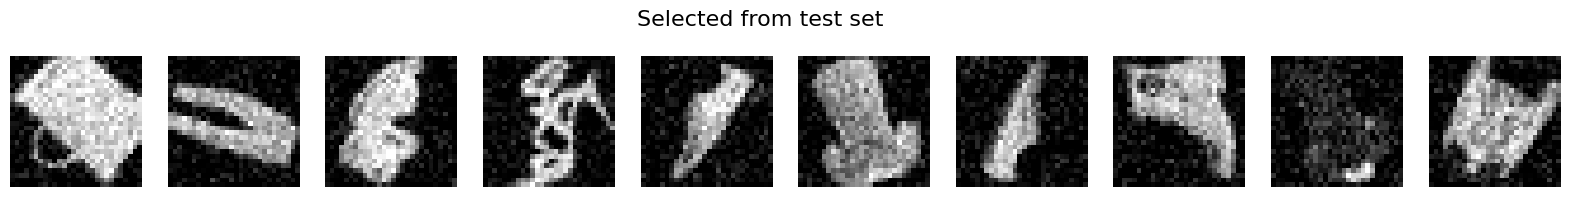

In [8]:
# Create a figure for plotting
fig, axes = plt.subplots(1, 10, figsize=(20, 2.3))

# Select 10 random objects from each class
random_indices_test = np.random.choice(np.arange(len(Xtest)), size=10, replace=False)
random_objects_test = Xtest[random_indices_test]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[i].matshow(random_objects_test[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from test set', fontsize=16)

plt.show()

The test set exhibits peculiarities that might pose challenges for the classifier's generalization ability. One noteworthy characteristic is the diversity in orientations and angles of objects in the test set compared to the training set. Unlike the training set, where objects are predominantly upright, the test set introduces instances with objects inverted or tilted.

This diversity in angles introduces a level of complexity for the classifier, as it needs to generalize across various viewpoints. Challenges lie in ensuring that the model can effectively learn and adapt to features regardless of the object's orientation.

### iii. Choosing the Right Metric
*Which performance metric would be best for this task (accuracy, AUC-ROC, AUC-PR, F1, Matthews correlation coefficient, mean squared error etc.)? Share your reasoning for this choice.*

Let's discuss the metrics and their suitability for this task:

1. **Accuracy**: In scenarios where the classes are imbalanced (as indicated by the uneven distribution of positive and negative examples in our training set), accuracy alone may not provide a complete picture.

2. **AUC-ROC**: Similarily, AUC-ROC is not a good metric for datasets with a lot more negative examples than positive ones.

3. **AUC-PR**: AUC-PR is particularly useful when dealing with imbalanced datasets. It focuses on the precision-recall trade-off and provides an informative metric when positive examples are rare.

4. **F1 Score**: F1 score, the harmonic mean of precision and recall, is suitable for imbalanced datasets and provides a balance between false positives and false negatives (precision and recall).

5. **Matthews Correlation Coefficient**: MCC takes into account true positives, true negatives, false positives, and false negatives. It is useful in providing a balanced measure of classification performance for imbalanced datasets.

6. **Mean Squared Error**: MSE is not a recommended metric for binary (discrete labels) classification tasks like object recognition, as it is designed for regression problems where the output is continuous.

In conclusion, AUC-PR, F1 score, and MCC may provide more meaningful insights than accuracy, AUC-ROC or MSE.

### iv. Benchmarking a Random Classifier
*Imagine a classifier that randomly guesses labels. What accuracy would you expect it to achieve on both the training and test datasets? Show this through a calculation, statistical proof, or a coding experiment.*

In [9]:
num_samples = Xtrain.shape[0]

# Randomly guess labels
# Take the sign of uniformly distributed values generated between -1 and 1
random_guesses = np.sign(np.random.uniform(-1, 1, size=num_samples))

# Calculate accuracy
accuracy = accuracy_score(Ytrain, random_guesses)
print(f"Accuracy on training dataset: {accuracy}")

Accuracy on training dataset: 0.5073333333333333


The random classifier is constructed by first generating random numbers uniformly distributed in the range from -1 to 1 and then transformed these values into class labels by taking their sign. The expected accuracy of this random (also a binary) classifier, regardless of the class distribution within a dataset, is 0.5 or 50% (there might be some variability due to the small size of the training and test dataset, but the observed accuracy is expected to be around 0.5).

For each single test point, the probability for the random classifier to predict -1 or +1 is both 50%, so the probability of guessing the lable correctly or incorrectly is also 50%. The expected accuracy of the whole training or test dataset can be expressed as *the number of correct predictions / total number of predictions*, thus for N data points we would have *0.5N / N = N*.

### v. Understanding AUC Metrics for Random Classifier
*What would be the AUC-ROC and AUC-PR for a random classifier in this context? Again, support your answer with a mathematical or statistical argument, or a practical demonstration.*

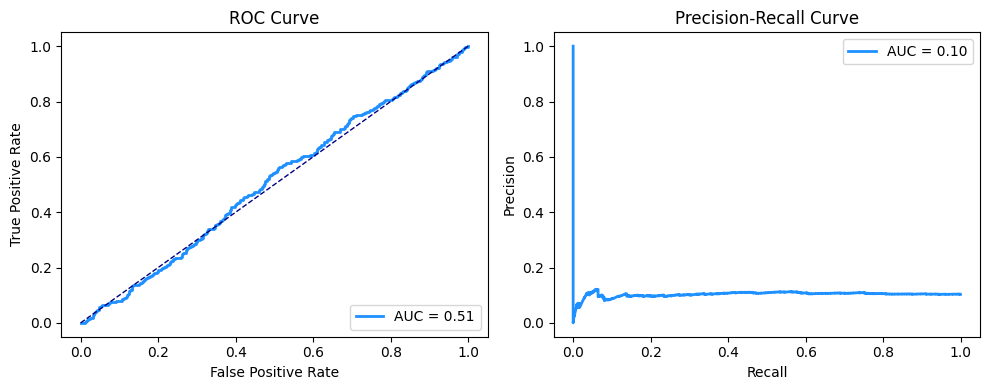

AUC-ROC for random classifier: 0.5090179234442094
AUC-PR for random classifier: 0.10300736016737355


In [10]:
num_samples = Xtrain.shape[0]

# Randomly guess labels
random_guesses = np.random.uniform(-1, 1, size=num_samples)

# ROC curve
fpr, tpr, _ = roc_curve(Ytrain, random_guesses)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(Ytrain, random_guesses)
pr_auc = auc(recall, precision)

# Plotting
plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='dodgerblue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"AUC-ROC for random classifier: {roc_auc}")
print(f"AUC-PR for random classifier: {pr_auc}")

For a random classifier, the Area Under the Receiver Operating Characteristic (AUC-ROC) curve and the Area Under the Precision-Recall (AUC-PR) curve are expected to be close to 0.5. Let's discuss the rationale behind this:

**AUC-ROC**: The ROC curve plots the True Positive Rate against the False Positive Rate. A random classifier would have a diagonal ROC curve, indicating that the True Positive Rate and False Positive Rate are changing at approximately the same speed from 0 to 1. Thus the AUC-ROC for a random classifier, representing the area under the diagonal line, is close to 0.5.

**AUC-PR**: The PR curve plots Precision against Recall. A random classifier would have a PR curve that looks like a vertical line (when the threshold is super small, Percision is 1 and Recall is 0) concatenated with a horizontal line (where precision is constant at the fraction of positives instances in the total data set, not influenced by specific prediction values). For example, the train dataset has 311 positive examples among 3000, so we end up with a AUC-PR value of around *311 / 3000 ≈ 0.1*.

<br>

## Question No. 2: Nearest Neighbour Classifier
*Perform 5-fold stratified cross-validation over the training dataset using a k-nearest neighbour (kNN) classifier.*

### i. K = 5 Nearest Neighbour Classifier

*Define and calculate the accuracy, balanced accuracy, AUC-ROC, AUC-PR, F1 and Matthews Correlation Coefficient for each fold using this classifier? Show code to demonstrate the results. Calculate the average and standard deviation for each metric across all folds and show these in a single table. As the KNN classifier in sklearn does not support decision_function, be sure to understand and use the predict_proba function for AUC-ROC and AUC-PR calculations or plotting.*

In [11]:
# Define the kNN classifier with k=5
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize lists to store metrics for each fold
accuracy_list = []
balanced_list = []
roc_auc_list = []
pr_auc_list = []
f1_list = []
mcc_list = []

# Saved for plotting curves later
probability_list = []
Y_test_fold_list = []

# Loop through each fold
for train_index, test_index in skf.split(Xtrain, Ytrain):
    X_train_fold, X_test_fold = Xtrain[train_index], Xtrain[test_index]
    Y_train_fold, Y_test_fold = Ytrain[train_index], Ytrain[test_index]

    # Fit the kNN classifier on the training data
    knn_classifier.fit(X_train_fold, Y_train_fold)

    # Make predictions on the test data
    predictions = knn_classifier.predict(X_test_fold)

    # Probability of positive class
    probabilities = knn_classifier.predict_proba(X_test_fold)[:, 1]
    probability_list.append(probabilities)
    Y_test_fold_list.append(Y_test_fold)

    # Calculate metrics for this fold
    accuracy_list.append(accuracy_score(Y_test_fold, predictions))
    balanced_list.append(balanced_accuracy_score(Y_test_fold, predictions))
    roc_auc_list.append(roc_auc_score(Y_test_fold, probabilities))

    # Compute precision-recall curve and area for this fold
    precision, recall, _ = precision_recall_curve(Y_test_fold, probabilities)
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)

    f1_list.append(f1_score(Y_test_fold, predictions))
    mcc_list.append(matthews_corrcoef(Y_test_fold, predictions))

# Display the results in a table
print(f"{'Metric':<20} {'Fold 1':<10} {'Fold 2':<10} {'Fold 3':<10} {'Fold 4':<10} {'Fold 5':<10}")
print("-" * 71)
print(f"{'Accuracy':<20} {accuracy_list[0]:<10.4f} {accuracy_list[1]:<10.4f} \
{accuracy_list[2]:<10.4f} {accuracy_list[3]:<10.4f} {accuracy_list[4]:<10.4f}")
print(f"{'Balanced Accuracy':<20} {balanced_list[0]:<10.4f} {balanced_list[1]:<10.4f} \
{balanced_list[2]:<10.4f} {balanced_list[3]:<10.4f} {balanced_list[4]:<10.4f}")
print(f"{'AUC-ROC':<20} {roc_auc_list[0]:<10.4f} {roc_auc_list[1]:<10.4f} \
{roc_auc_list[2]:<10.4f} {roc_auc_list[3]:<10.4f} {roc_auc_list[4]:<10.4f}")
print(f"{'AUC-PR':<20} {pr_auc_list[0]:<10.4f} {pr_auc_list[1]:<10.4f} \
{pr_auc_list[2]:<10.4f} {pr_auc_list[3]:<10.4f} {pr_auc_list[4]:<10.4f}")
print(f"{'F1 Score':<20} {f1_list[0]:<10.4f} {f1_list[1]:<10.4f} \
{f1_list[2]:<10.4f} {f1_list[3]:<10.4f} {f1_list[4]:<10.4f}")
print(f"{'MCC':<20} {mcc_list[0]:<10.4f} {mcc_list[1]:<10.4f} \
{mcc_list[2]:<10.4f} {mcc_list[3]:<10.4f} {mcc_list[4]:<10.4f}")

Metric               Fold 1     Fold 2     Fold 3     Fold 4     Fold 5    
-----------------------------------------------------------------------
Accuracy             0.9117     0.9200     0.8950     0.9100     0.9083    
Balanced Accuracy    0.7367     0.7342     0.6703     0.6858     0.7176    
AUC-ROC              0.8620     0.8704     0.8417     0.8383     0.8082    
AUC-PR               0.5459     0.6165     0.4936     0.5781     0.5364    
F1 Score             0.5470     0.5636     0.4324     0.4808     0.5217    
MCC                  0.4994     0.5256     0.3786     0.4434     0.4742    


In [12]:
# Calculate average and standard deviation for each metric
avg_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

avg_balanced = np.mean(balanced_list)
std_balanced = np.std(balanced_list)

avg_roc_auc = np.mean(roc_auc_list)
std_roc_auc = np.std(roc_auc_list)

avg_pr_auc = np.mean(pr_auc_list)
std_pr_auc = np.std(pr_auc_list)

avg_f1 = np.mean(f1_list)
std_f1 = np.std(f1_list)

avg_mcc = np.mean(mcc_list)
std_mcc = np.std(mcc_list)

# Display the results in a table
print(f"{'Metric':<20} {'Average':<10} {'Standard Deviation':<20}")
print("-" * 50)
print(f"{'Accuracy':<20} {avg_accuracy:<10.4f} {std_accuracy:<20.4f}")
print(f"{'Balanced Accuracy':<20} {avg_balanced:<10.4f} {std_balanced:<20.4f}")
print(f"{'AUC-ROC':<20} {avg_roc_auc:<10.4f} {std_roc_auc:<20.4f}")
print(f"{'AUC-PR':<20} {avg_pr_auc:<10.4f} {std_pr_auc:<20.4f}")
print(f"{'F1 Score':<20} {avg_f1:<10.4f} {std_f1:<20.4f}")
print(f"{'MCC':<20} {avg_mcc:<10.4f} {std_mcc:<20.4f}")

Metric               Average    Standard Deviation  
--------------------------------------------------
Accuracy             0.9090     0.0081              
Balanced Accuracy    0.7089     0.0265              
AUC-ROC              0.8441     0.0216              
AUC-PR               0.5541     0.0413              
F1 Score             0.5091     0.0474              
MCC                  0.4642     0.0507              


### ii. ROC and PR Curves for One Fold

*What are your observations about the ROC and PR curves? What  part of the ROC curve is more important for this problem?*

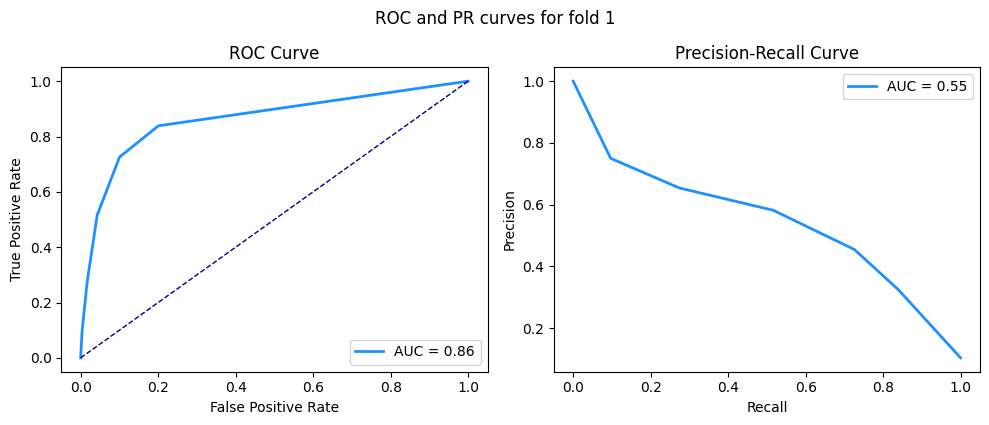

In [13]:
# Choose a fold randomly
fold_index = random.randint(0, 4)
probabilities = probability_list[fold_index]
Y_test_fold = Y_test_fold_list[fold_index]

# Compute ROC curve and ROC area for the selected fold
fpr, tpr, _ = roc_curve(Y_test_fold, probabilities)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve and area for the selected fold
precision, recall, _ = precision_recall_curve(Y_test_fold, probabilities)
pr_auc = auc(recall, precision)

# Plotting
plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='dodgerblue', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.tight_layout()
plt.suptitle(f"ROC and PR curves for fold {fold_index+1}", y=1.05)
plt.show()

The ROC curve is above the diagonal line, indicating that the performance of the KNN classifier is superior to that of a random classifier. Additionally, the curve ascends more rapidly in the initial stages, further emphasizing the classifier's effectiveness. The PR curve closely approximates a diagonal line with a slope of -1, suggesting that when one of precision or recall increases, the decrease in the other is symmetrical. This signifies a balanced trade-off between precision and recall for the classifier.

Given an unbalanced test set where negative examples far outnumber positive ones, the crucial part of the ROC curve is near the top-left corner. This region corresponds to pursuing low false positive rates. In imbalanced datasets where the negative class is dominant, minimizing False Positive Rate is crucial to avoid misclassifying the majority of instances that are negative, otherwise it is possible to have a seemingly small FPR but still a large number of negative instances incorrectly classified as positive.

### iii. Explore Pre-processing Techniques

*What is the impact of various forms of pre-processing (e.g., mean-standard deviation or standard scaling or min-max scaling) on the cross-validation performance? Show code to demonstrate the results and write a summary of your findings. Do any pre-processing techniques improve predictive performance or training speed? Why do you think this is the case?*

In [14]:
# Define the preprocessors
preprocessors = {
    'No Scaling': None,  # Placeholder for no scaling
    'Standard Scaling': StandardScaler(),
    'Min-Max Scaling': MinMaxScaler()
}

# Define the classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Add a new function to calculate PR AUC
def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Define the metrics to evaluate
metrics = {
    'Accuracy': accuracy_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'ROC AUC': roc_auc_score,
    'PR AUC': pr_auc_score,
    'F1 Score': f1_score,
    'MCC': matthews_corrcoef
}

print('='*51)

# Loop through each pre-processing method
for preprocessor_name, preprocessor in preprocessors.items():
    print(f"Results for {preprocessor_name}:\n{'-'*51}")
        
    # Apply preprocessor if not None
    # If no preprocessor, use original data
    if preprocessor:
        Xtrain_scaled = preprocessor.fit_transform(Xtrain)
    else:
        Xtrain_scaled = Xtrain

    # Perform 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    metric_values_list = {metric_name: [] for metric_name in metrics}
    total_training_time = 0

    for train_index, test_index in skf.split(Xtrain_scaled, Ytrain):
        X_train_fold, X_test_fold = Xtrain_scaled[train_index], Xtrain_scaled[test_index]
        Y_train_fold, Y_test_fold = Ytrain[train_index], Ytrain[test_index]

        # Fit the classifier on the training data
        start_time = time.time()
        knn_classifier.fit(X_train_fold, Y_train_fold)
        end_time = time.time()
        total_training_time += end_time - start_time

        # Loop through each metric
        for metric_name, metric_func in metrics.items():
            # Make predictions on the test data
            predictions = knn_classifier.predict(X_test_fold)
            probabilities = knn_classifier.predict_proba(X_test_fold)[:, 1]

            # Calculate the metric for this fold
            if metric_name in ['ROC AUC', 'PR AUC']:
                metric_value = metric_func(Y_test_fold, probabilities)
            else:
                metric_value = metric_func(Y_test_fold, predictions)
            metric_values_list[metric_name].append(metric_value)

    # Print the average and standard deviation of the metrics across all folds
    for metric_name, metric_values in metric_values_list.items():
        average_value = np.mean(metric_values)
        std_dev_value = np.std(metric_values)
        print(f"Average {metric_name}: {average_value:.4f} (Std Dev: {std_dev_value:.4f})")
    
    print(f"Average training time: {(total_training_time/5):.4f}")
    print('='*51)

Results for No Scaling:
---------------------------------------------------
Average Accuracy: 0.9100 (Std Dev: 0.0048)
Average Balanced Accuracy: 0.7094 (Std Dev: 0.0175)
Average ROC AUC: 0.8650 (Std Dev: 0.0191)
Average PR AUC: 0.5875 (Std Dev: 0.0149)
Average F1 Score: 0.5121 (Std Dev: 0.0292)
Average MCC: 0.4682 (Std Dev: 0.0301)
Average training time: 0.0059
Results for Standard Scaling:
---------------------------------------------------
Average Accuracy: 0.9090 (Std Dev: 0.0039)
Average Balanced Accuracy: 0.7189 (Std Dev: 0.0181)
Average ROC AUC: 0.8661 (Std Dev: 0.0156)
Average PR AUC: 0.5667 (Std Dev: 0.0224)
Average F1 Score: 0.5212 (Std Dev: 0.0258)
Average MCC: 0.4744 (Std Dev: 0.0259)
Average training time: 0.0045
Results for Min-Max Scaling:
---------------------------------------------------
Average Accuracy: 0.9123 (Std Dev: 0.0048)
Average Balanced Accuracy: 0.7165 (Std Dev: 0.0193)
Average ROC AUC: 0.8539 (Std Dev: 0.0180)
Average PR AUC: 0.5868 (Std Dev: 0.0233)
Avera

The impact of applying a scaler to a KNN classifier on predictive performance is limited. Some factors to consider:

1. **Distance Metric**: KNN relies on distance metrics to determine the neighbors of a data point. Rescaling features doesn't affect the relative distances between points, as it merely stretches or compresses the feature space uniformly.

2. **Feature Distributions**: KNN makes minimal assumptions about the underlying distribution of features. If the original feature distributions are not significantly skewed, normalization might not yield substantial improvements.

3. **Robustness to Outliers**: KNN is generally robust to outliers since it looks at the majority class among its neighbors. Feature scaling might not have a pronounced impact on the algorithm's behavior in the presence of outliers.

In summary, the inherent characteristics of the KNN algorithm, which focuses on local relationships, make it less sensitive to the absolute scale of features. Consequently, the application of scaling may not lead to significant performance improvements.

<br>

Some possible explanations for the consistent training speed across different scaling methods:

1. **Computational Complexity**: The primary computational cost of KNN comes during the prediction phase when distances need to be calculated for each test instance against all training instances. This step is unaffected by feature scaling.

2. **Data Size**: For small datasets, the overhead of scaling might be negligible compared to the overall training time.

Most importantly, the KNN algorithm's nature provides a consistent training speed regardless of feature scaling.

<br>

## Question No. 3: Cross-validation of SVM and RFs

*Use 5-fold stratified cross-validation over training data to choose an optimal classifier between: SVMs (linear, polynomial kernels and Radial Basis Function Kernels) and Random Forest Classifiers. Be sure to tune the hyperparameters of each classifier type (C and kernel type and kernel hyper-parameters for SVMs, the number of trees, depth of trees etc. for the Random Forests etc). Report the cross validation results (mean and standard deviation of accuracy, balanced accuracy, AUC-ROC and AUC-PR across fold) of your best model. You may look into grid search as well as ways of pre-processing data.*

### i. Selecting the Optimal Classifier

*Write your strategy for selecting the optimal classifier. Show code to demonstrate the results for each classifier.*

Intuitively, SVM may benefit more from using a scaler for data preprocessing compared to Random Forest or KNN.

1. **Distance-based Decision Boundary**: SVM aims to find a decision boundary that maximizes the margin between different classes. This boundary is often influenced by the distances between data points. Scaling ensures that all features contribute proportionally to the distance calculations, preventing features with larger scales from dominating the decision.

2. **Sensitivity to Feature Scales**: SVM is sensitive to the scales of features, especially when using radial basis function (RBF) kernels. Features with larger scales may have a stronger impact, potentially leading to a bias. Scaling helps in ensuring that all features have a similar influence on the model, making the optimization process more effective.

In contrast, Random Forest constructs decision trees based on feature thresholds and doesn't rely on distance metrics. The ensemble nature of RF, where multiple trees are combined, makes it less sensitive to individual feature scales.

But if we do want to preprocess the data with a scaler, which one should we choose?

In [4]:
standard = StandardScaler()
Xtrain_standard = standard.fit_transform(Xtrain)
Xtest_standard = standard.fit_transform(Xtest)

minmax = MinMaxScaler()
Xtrain_minmax = minmax.fit_transform(Xtrain)
Xtest_minmax = minmax.fit_transform(Xtest)

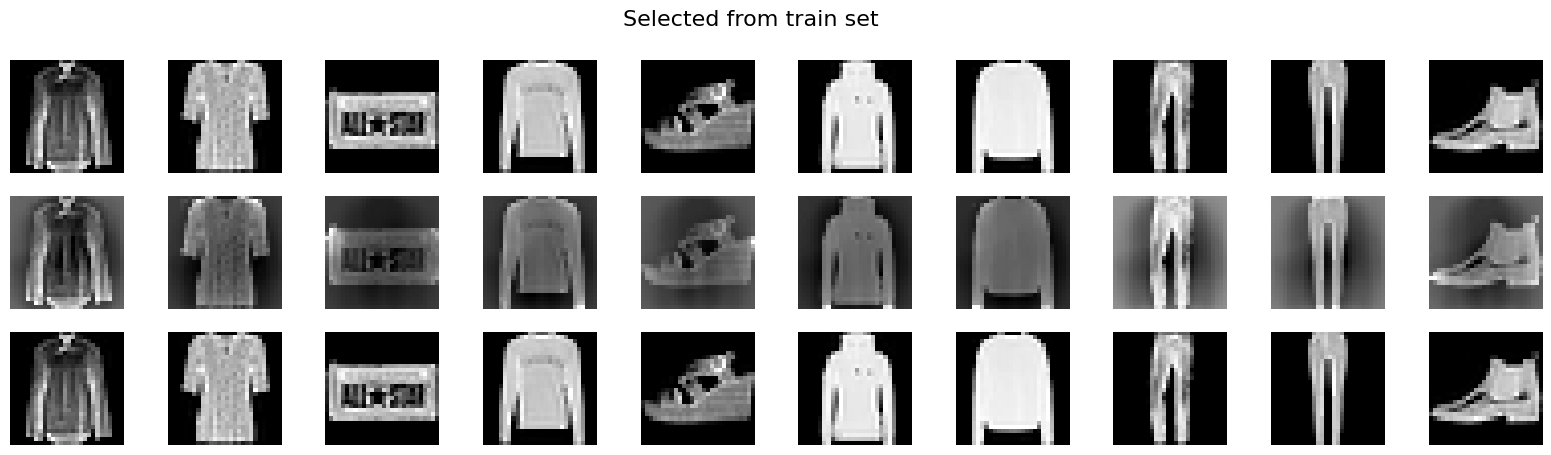

In [26]:
# Create a figure for plotting
fig, axes = plt.subplots(3, 10, figsize=(20, 5))

# Select 10 random objects from each class
random_indices_train = np.random.choice(np.arange(len(Xtrain)), size=10, replace=False)
random_objects_train = Xtrain[random_indices_train]
random_objects_train_standard = Xtrain_standard[random_indices_train]
random_objects_train_minmax = Xtrain_minmax[random_indices_train]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_train[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_train_standard[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].matshow(random_objects_train_minmax[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from train set', fontsize=16)

plt.show()

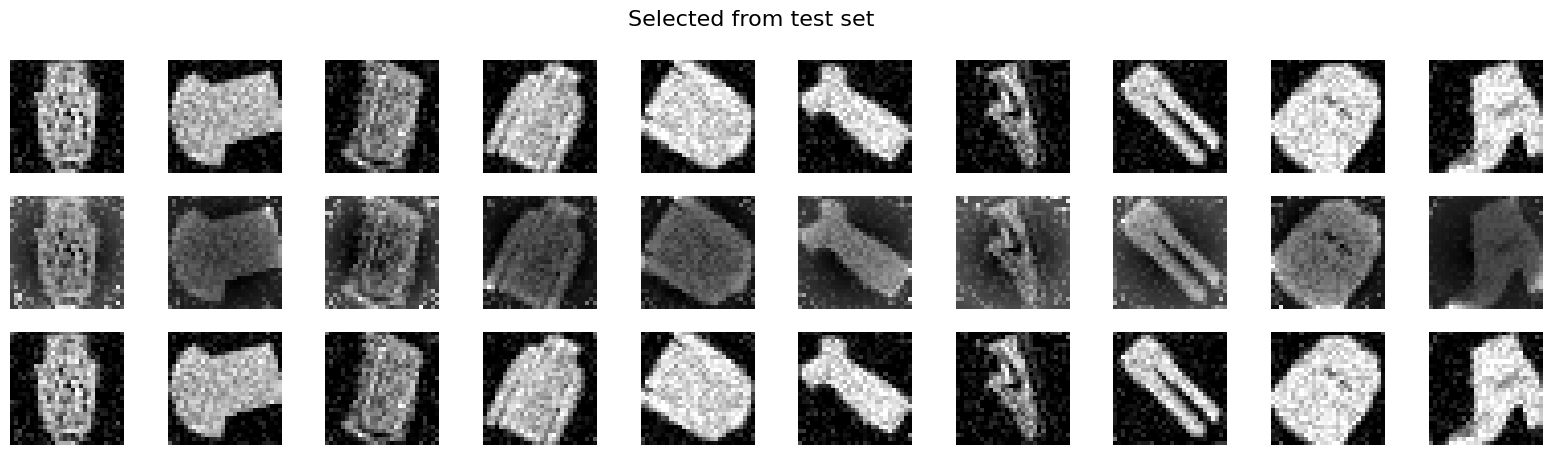

In [27]:
# Create a figure for plotting
fig, axes = plt.subplots(3, 10, figsize=(20, 5))

# Select 10 random objects from each class
random_indices_test = np.random.choice(np.arange(len(Xtest)), size=10, replace=False)
random_objects_test = Xtest[random_indices_test]
random_objects_test_standard = Xtest_standard[random_indices_test]
random_objects_test_minmax = Xtest_minmax[random_indices_test]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_test_standard[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].matshow(random_objects_test_minmax[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from test set', fontsize=16)

plt.show()

Through visualizing the images we can see that min-max scaled data (the third row) preserves the information from the original data (the first row) better than standard scaled (the second row). So it would be better to use the min-max scaler.

We start by performing grid search on the raw data without preprocessing using a scaler. We use Matthews correlation coefficient as the evaluation metric and perform 5-fold stratified cross-validation over training data.

For SVMs, we use these initial hyperparameter ranges for the grid search:

- Kernel: ['linear', 'poly', 'rbf']
- C (Regularization parameter): [0.001, 0.01, 0.1, 1, 10, 100, 1000]
- Degree (for 'poly' kernel): [2, 3, 4, 5]
- Gamma (for 'rbf' kernel): [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [1]:
def grid_search(classifier, param_grid, X, Y):
    # Initialize GridSearchCV
    grid_search_cv = GridSearchCV(classifier, param_grid=param_grid, \
        scoring='matthews_corrcoef', cv=5, n_jobs=-1)
    
    # Perform grid search on the training data
    grid_search_cv.fit(X, Y)
    
    return grid_search_cv

def sorted_score(grid_search_cv):
    # Get the results of the grid search
    results = grid_search_cv.cv_results_

    # Create a list to store relevant information
    relevant_info = []

    # Iterate through each parameter combination
    for i in range(len(results['params'])):
        params = results['params'][i]
        mean_mcc = results['mean_test_score'][i]
        std_mcc = results['std_test_score'][i]
        relevant_info.append({'params': params, 'mean_mcc': mean_mcc, 'std_mcc': std_mcc})

    # Sort the relevant information by mean MCC in descending order
    relevant_info.sort(key=lambda x: x['mean_mcc'], reverse=True)

    return relevant_info

In [23]:
# Define the parameter grid for SVM
param_grid_svm = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['poly'],
        'degree': [2, 3, 4, 5],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['rbf'],
        'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

In [16]:
# Create the SVM classifier and perform grid search
svm_search = grid_search(SVC(probability=True), param_grid_svm, Xtrain, Ytrain)

# Print the best parameters
print("Best Parameters", svm_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", svm_search.best_score_)

Best Parameters {'C': 100, 'degree': 2, 'kernel': 'poly'}
Best MCC score: 0.5840522412675488


The best parameters obtained from grid search on the raw data are 'C': 100, 'degree': 2, 'kernel': 'poly'. This implies that the optimal SVM model is a polynomial kernel SVM with the regularization parameter set to 100 and the degree set to 2. The model achieved an average MCC score of 0.5841 on cross-validation, surpassing the performance of the previous KNN model.

In [17]:
relevant_info = sorted_score(svm_search)

# Print the sorted information
for info in relevant_info:
    if (info['mean_mcc'] > 0):
        print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.5841          Std: 0.0932
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.5794          Std: 0.0686
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.5749          Std: 0.0860
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.5640          Std: 0.0536
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.5626          Std: 0.0748
{'C': 10, 'degree': 2, 'kernel': 'poly'}           Mean: 0.5325          Std: 0.0652
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.5324          Std: 0.0335
{'C': 1000, 'degree': 5, 'kernel': 'poly'}         Mean: 0.5145          Std: 0.0594
{'C': 10, 'degree': 3, 'kernel': 'poly'}           Mean: 0.5048          Std: 0.0813
{'C': 1, 'degree': 4, 'kernel': 'poly'}            Mean: 0.4933          Std: 0.0569
{'C': 1, 'degree': 5, 'kernel': 'poly'}            Mean: 0.4761          Std: 0.0534
{'C': 100, 'degree': 5, 'kernel': 'poly'}          Mean: 0.4735  

Sorting the parameter combinations based on the MCC score, it can be observed that the polynomial kernel SVM performs the best on the raw data, followed by the linear kernel, and the RBF kernel performs the worst. We do not display combinations with MCC values equal to or less than 0, whose predictive performance is the same as or worse than random guessing.

<br>

For Random Forest, we use these initial hyperparameter ranges:

- Number of Trees: [50, 100, 200, 300]
- Maximum Depth of Trees: [None, 10, 20, 30]
- Minimum Samples Split: [2, 5, 10]
- Minimum Samples Leaf: [1, 2, 4]

In [24]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [18]:
# Create the RF classifier and perform grid search
rf_search = grid_search(RandomForestClassifier(random_state=42), param_grid_rf, Xtrain, Ytrain)

# Print the best parameters
print("Best Parameters", rf_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", rf_search.best_score_)

Best Parameters {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MCC score: 0.5143262645404302


The optimal parameters for the random forest model obtained from grid search suggests that the model prefers using a relatively large number of trees, with each tree having unrestricted depth, and each leaf node containing at least one sample. Internal nodes need at least two samples to split. Overall, it represents a flexible and complex random forest model.

In [19]:
relevant_info = sorted_score(rf_search)

# Print the sorted information
print("Top 10 parameter combinations:\n" + '-'*117)
for info in relevant_info[:10]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

print("\nBottom 10 parameter combinations:\n" + '-'*117)
for info in relevant_info[-10:]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

Top 10 parameter combinations:
---------------------------------------------------------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}    Mean: 0.5143   Std: 0.0554
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}    Mean: 0.5021   Std: 0.0560
{'max_depth': 20, 'min_sa

Sorting the parameter combinations based on the MCC score, it can be observed that the MCC scores of the Random Forest range roughly between 0.45 and 0.52. Adjusting the parameters has limited impact on the model's performance.

In [25]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance (L1), 2 for Euclidean distance (L2)
}

In [20]:
# Create the KNN classifier and perform grid search
knn_search = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain, Ytrain)

# Print the best parameters
print("Best Parameters", knn_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", knn_search.best_score_)

Best Parameters {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best MCC score: 0.5045358831934272


In [28]:
relevant_info = sorted_score(knn_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<60} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}            Mean: 0.5045          Std: 0.0321
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}            Mean: 0.5040          Std: 0.0433
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}            Mean: 0.5006          Std: 0.0410
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}            Mean: 0.4942          Std: 0.0662
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}            Mean: 0.4942          Std: 0.0287
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}            Mean: 0.4921          Std: 0.0190
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}            Mean: 0.4898          Std: 0.0512
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}            Mean: 0.4883          Std: 0.0179
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}             Mean: 0.4847          Std: 0.0377
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}             Mean: 0.4814          Std: 0.0295
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}  

The optimal KNN classifier found for raw dataset considers the labels of the five nearest neighbors using the Manhattan distance. Assigning higher importance to closer neighbors generally gives better performance than treating them with equal weights, while the number of neighbours taken into consideration and the distance function seem to matter less.

<br>

We then apply the same grid search strategies, but this time on preprocessed data using min-max scaling.

In [8]:
# Perform SVM grid search on min-max scaled dataset
scaled_svm_search = grid_search(SVC(probability=True), param_grid_svm, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Best Parameters", scaled_svm_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", scaled_svm_search.best_score_)

Best Parameters {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best MCC score: 0.617973943372599


The best parameters obtained on the scaled data are 'C': 100, 'gamma': 0.01, 'kernel': 'rbf'. This implies that the optimal SVM model is a Radial Basis Function kernel SVM with the regularization parameter set to 100 and gamma value set to 0.01.

In [9]:
relevant_info = sorted_score(scaled_svm_search)

# Print the sorted information
for info in relevant_info:
    if (info['mean_mcc'] > 0):
        print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}         Mean: 0.6180          Std: 0.0617
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}        Mean: 0.6180          Std: 0.0617
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}          Mean: 0.6108          Std: 0.0512
{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.5852          Std: 0.0904
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.5772          Std: 0.0662
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.5747          Std: 0.0914
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.5681          Std: 0.0491
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}       Mean: 0.5626          Std: 0.0632
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.5577          Std: 0.0657
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}        Mean: 0.5513          Std: 0.0302
{'C': 10, 'degree': 2, 'kernel': 'poly'}           Mean: 0.5316          Std: 0.0633
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.5273  

With a scaled dataset, the RBF kernel SVM can outperform linear and polynomial ones.

The best score given by the latter two also improved, but not as much.

In [12]:
# Perform RF grid search on min-max scaled dataset
scaled_rf_search = grid_search(RandomForestClassifier(random_state=42), param_grid_rf, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Best Parameters", scaled_rf_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", scaled_rf_search.best_score_)

Best Parameters {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MCC score: 0.5143262645404302


In [13]:
relevant_info = sorted_score(scaled_rf_search)

# Print the sorted information
print("Top 10 parameter combinations:\n" + '-'*117)
for info in relevant_info[:10]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

print("\nBottom 10 parameter combinations:\n" + '-'*117)
for info in relevant_info[-10:]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

Top 10 parameter combinations:
---------------------------------------------------------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}    Mean: 0.5143   Std: 0.0554
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}    Mean: 0.5021   Std: 0.0560
{'max_depth': 20, 'min_sa

Consistent with our intuition, scaling does not have a significant impact on the performance of the Random Forest.

In [14]:
# Perform KNN grid search on min-max scaled dataset
scaled_knn_search = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Best Parameters", scaled_knn_search.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", scaled_knn_search.best_score_)

Best Parameters {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best MCC score: 0.5028279457048647


In [15]:
relevant_info = sorted_score(scaled_knn_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<60} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}            Mean: 0.5028          Std: 0.0437
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}            Mean: 0.5027          Std: 0.0628
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}            Mean: 0.5019          Std: 0.0319
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}            Mean: 0.5011          Std: 0.0419
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}            Mean: 0.4975          Std: 0.0228
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}            Mean: 0.4969          Std: 0.0281
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}            Mean: 0.4912          Std: 0.0513
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}            Mean: 0.4871          Std: 0.0192
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}             Mean: 0.4836          Std: 0.0383
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}             Mean: 0.4786          Std: 0.0309
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}  

The optimal KNN model for scaled dataset considers the three nearest neighbours and uses Euclidean distance. As previously shown in Question 2, scaling does not have a significant impact on the performance of the KNN either.

### ii. Comparison of Classifiers

*Show the comparison of these classifiers in a single consolidated table.*

We calculate the average accuracy, balanced accuracy, AUC-ROC, AUC-PR, F1 and MCC based on 5-fold stratified cross-validation for the following classifiers with optimal parameters over the training data preprocessed using min-max scaling:

1. **K Nearest Neighbour** (n_neighbors=3, p=2, weights='distance');
2. **Linear kernel SVM** (C=0.1);
3. **Polynomial kernel SVM** (C=100, degree=2);
4. **Radial Basis Function kernel SVM** (C=100, gamma=0.01);
5. **Random Forest** (max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100).

In [31]:
def compare_classifiers(classifiers, X, Y):

    # Add a new function to calculate PR AUC
    def pr_auc_score(y_true, y_pred):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        return auc(recall, precision)

    metrics = {
        'Accuracy': accuracy_score,
        'Balanced Accuracy': balanced_accuracy_score,
        'ROC AUC': roc_auc_score,
        'PR AUC': pr_auc_score,
        'F1 Score': f1_score,
        'MCC': matthews_corrcoef
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    metric_values_dict = {classifier_name: {metric_name: [] \
        for metric_name in metrics} \
        for classifier_name in classifiers}

    for train_index, test_index in skf.split(X, Y):
        # print("Using the same split for all classifiers.")
        for classifier_name, classifier in classifiers.items():
            # print(f"Evaluating {classifier_name}:")
            for metric_name, metric_func in metrics.items():
                X_train_fold, X_test_fold = X[train_index], X[test_index]
                y_train_fold, y_test_fold = Y[train_index], Y[test_index]

                # Fit the classifier on the training data
                classifier.fit(X_train_fold, y_train_fold)

                # Make predictions on the test data
                predictions = classifier.predict(X_test_fold)
                probabilities = classifier.predict_proba(X_test_fold)[:, 1]

                # Calculate the metric for this fold
                if metric_name in ['ROC AUC', 'PR AUC']:
                    metric_value = metric_func(y_test_fold, probabilities)
                else:
                    metric_value = metric_func(y_test_fold, predictions)
                
                # Save the metric value
                metric_values_dict[classifier_name][metric_name].append(metric_value)

    print(f"{'Classifier':<15}{'Accuracy':<15}{'Balanced':<15}\
{'AUC-ROC':<15}{'AUC-PR':<15}{'F1 Score':<15}{'MCC':<15}")

    for classifier_name, metrics_dict in metric_values_dict.items():
        print(f"{classifier_name:<15}", end='')

        for metric_name, values in metrics_dict.items():
            average_value = np.mean(values)
            print(f"{average_value:<15.4f}", end='')

        print()

In [25]:
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=3, p=2, weights='distance'),
    'Linear SVM': SVC(probability=True, C=0.1, kernel='linear'),
    'Poly SVM': SVC(probability=True, C=100, degree=2, kernel='poly'),
    'RBF SVM': SVC(probability=True, C=100, gamma=0.01, kernel='rbf'),
    'RF': RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, 
        min_samples_split=2, n_estimators=100)
}

compare_classifiers(classifiers, Xtrain_minmax, Ytrain)

Classifier     Accuracy       Balanced       AUC-ROC        AUC-PR         F1 Score       MCC            
KNN            0.9137         0.7413         0.8468         0.6076         0.5573         0.5113         
Linear SVM     0.9203         0.7139         0.9093         0.6198         0.5402         0.5109         
Poly SVM       0.9267         0.8042         0.9241         0.6435         0.6500         0.6095         
RBF SVM        0.9327         0.7904         0.9350         0.7279         0.6536         0.6193         
RF             0.9250         0.6510         0.9376         0.7186         0.4561         0.5034         


The Radial Basis Function SVM exhibits the most comprehensive performance across all metrics.

### iii. ROC Curves

*Plot the ROC curves of all classifiers on the same axes for easy comparison.*

### iv. PR Curves

*Plot the PR curves of all classifiers on the same axes for comparison.*

In [34]:
def roc_pr_folds_plot(classifiers, X, Y):

    # Create subplots
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))
    fig.subplots_adjust(hspace=0.25)

    # 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    fold_index = 0

    # Loop through each fold
    for train_index, test_index in skf.split(X, Y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]

        # Plot ROC and PR curves for each classifier
        for classifier_name, classifier in classifiers.items():
            classifier.fit(X_train_fold, Y_train_fold)

            # Get the probability scores for the positive class
            scores = classifier.predict_proba(X_test_fold)[:, 1]

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(Y_test_fold, scores)
            roc_auc = auc(fpr, tpr)

            # Compute precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test_fold, scores)
            pr_auc = auc(recall, precision)

            # Plot ROC curve
            axs[fold_index, 0].plot(fpr, tpr, label=f'{classifier_name} (ROC-AUC = {roc_auc:.2f})')

            # Plot PR curve
            axs[fold_index, 1].plot(recall, precision, label=f'{classifier_name} (PR-AUC = {pr_auc:.2f})')

        # Set plot details for ROC curve
        axs[fold_index, 0].set_title('ROC Curves for fold ' + str(fold_index+1))
        axs[fold_index, 0].set_xlabel('False Positive Rate')
        axs[fold_index, 0].set_ylabel('True Positive Rate')
        axs[fold_index, 0].legend(loc='lower right')

        # Set plot details for PR curve
        axs[fold_index, 1].set_title('PR Curves for fold ' + str(fold_index+1))
        axs[fold_index, 1].set_xlabel('Recall')
        axs[fold_index, 1].set_ylabel('Precision')
        axs[fold_index, 1].legend(loc='lower left')

        fold_index += 1

    # Show the plots
    plt.show()

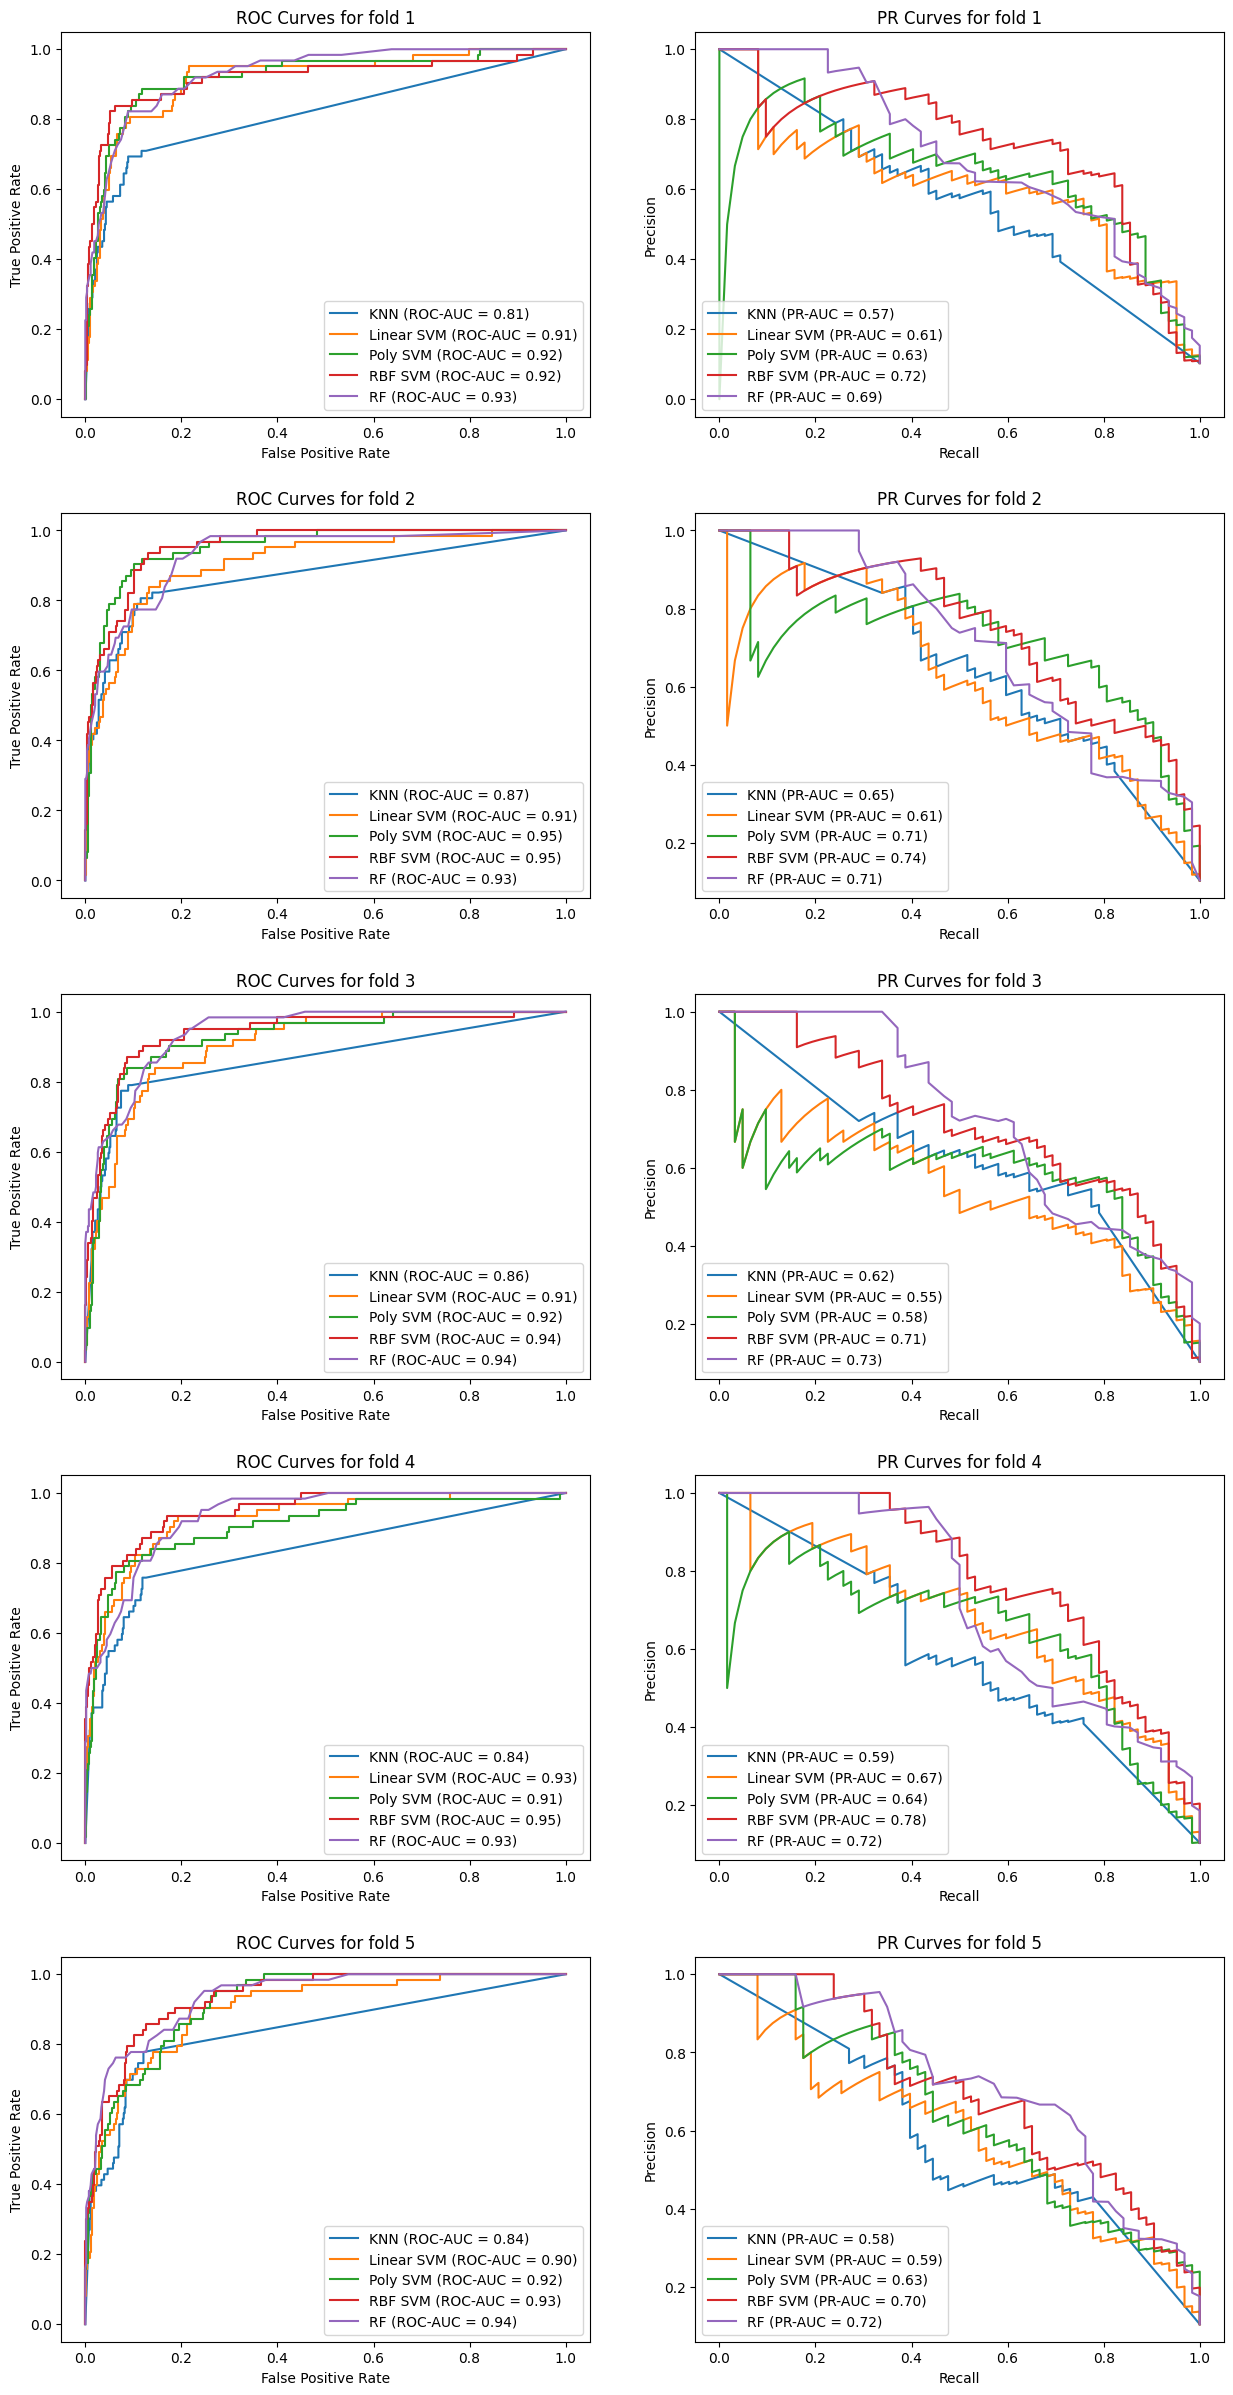

In [27]:
roc_pr_folds_plot(classifiers, Xtrain_minmax, Ytrain)

### v. Write your observations about the ROC and PR curves. 

A good ROC curve (for our unbalanced dataset) should exhibit the following characteristic:

- **Steep Increase in the Beginning**: A good ROC curve would ascend sharply toward the top-left corner. This indicates that the model effectively identifies true positives while minimizing false positives.

A good PR curve should exhibit the following characteristics:

1. **Steep Increase in the Beginning**: A good PR curve often exhibits a steep increase in precision with a small decrease in recall, especially in the initial phase. This indicates that the model can identify positive instances with high confidence.

2. **Smoothness**: Abrupt changes or dips may suggest inconsistencies in the model's behavior.

Consider these, we may prefer RBF SVM as the best classifier, for its ROC curve ascends the most sharply toward the top-left corner when FPR is low, and its PR curve is relatively smooth compared to that of linear or polynomial SVM.

## Question No. 4: PCA

### i. Dimension Reduction
*Reduce the number of dimensions of the training data using PCA to 2 and plot a scatter plot of the training data showing examples of each class in a different colour. What are your observations about the data based on this plot?*

In [30]:
# Apply PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(Xtrain)

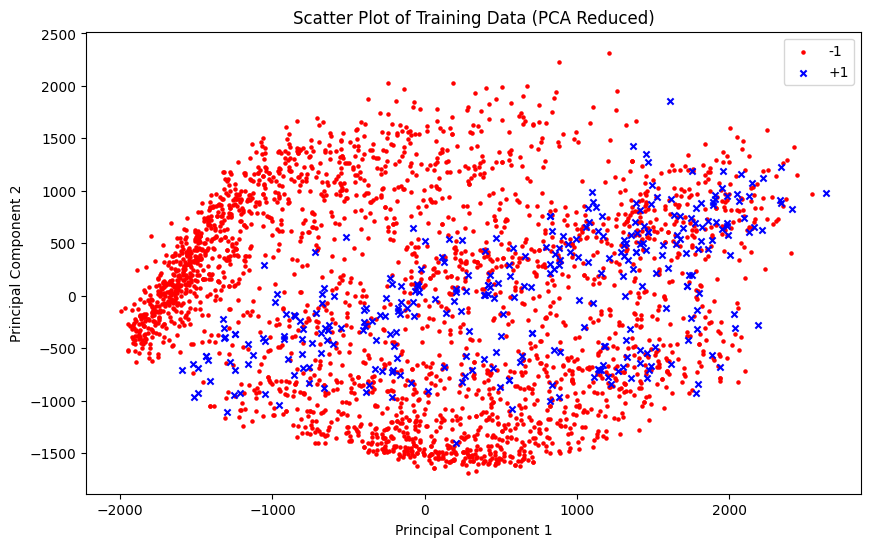

In [31]:
plt.figure(figsize=(10, 6))

# Create a scatter plot with different colors for each class
plt.scatter(X_reduced[Ytrain == -1, 0], X_reduced[Ytrain == -1, 1], \
    label='-1', c='red', marker='.', s=20)
plt.scatter(X_reduced[Ytrain == 1, 0], X_reduced[Ytrain == 1, 1], \
    label='+1', c='blue', marker='x', s=20)

# Add labels and a legend
plt.title('Scatter Plot of Training Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

In the scatter plot, we observe significant overlap between data points labeled +1 and -1. Specifically, training samples labeled -1 exhibit a more diverse distribution, while those labeled +1 only cover a subset. This aligns with concerns raised during the data exploration stage, where it was noted that nearly all images labeled +1 represent upper garments, whereas images labeled -1 encompass a variety of items, including upper and lower clothing, shoes, and bags. Thus, the positive and negative labels seem to approximate the criterion of "whether it is an upper garment. However, based on this criterion, there may be challenges in the accuracy of data labeling, as some images representing upper garments may have been wrongly labeled as -1.

### ii. Training and Test Data

*Reduce the number of dimensions of the training and test data together using PCA to 2 and plot a scatter plot of the training and test data showing examples of each set in a different colour. What are your observations about the data based on this plot?*

In [32]:
# Concatenate training and test data for joint PCA
X_combined = np.vstack((Xtrain, Xtest))

# Apply PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
X_combined_reduced = pca.fit_transform(X_combined)

# Separate the combined data back into training and test data
Xtrain_reduced = X_combined_reduced[:len(Xtrain)]
Xtest_reduced = X_combined_reduced[len(Xtrain):]

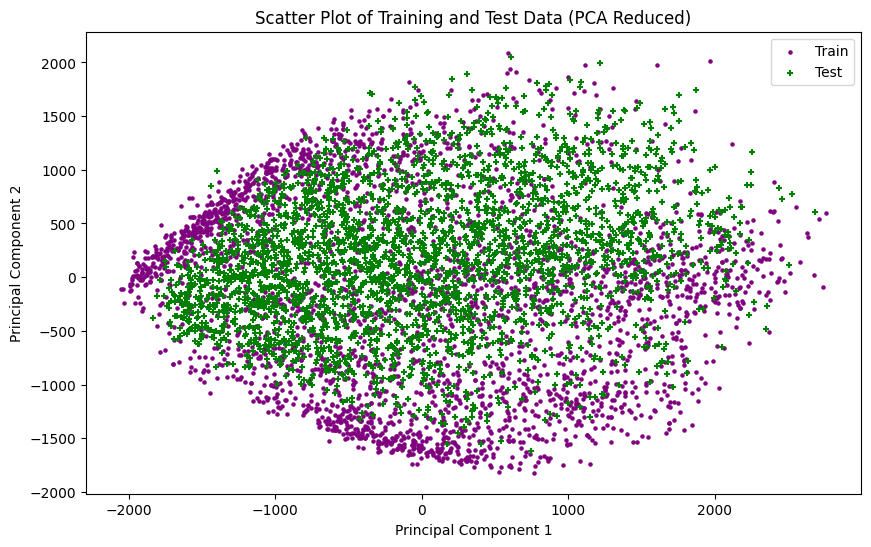

In [33]:
plt.figure(figsize=(10, 6))

# Create a scatter plot with different colors for training and test data
plt.scatter(Xtrain_reduced[:, 0], Xtrain_reduced[:, 1], \
    label='Train', c='purple', marker='.', s=20)
plt.scatter(Xtest_reduced[:, 0], Xtest_reduced[:, 1], \
    label='Test', c='green', marker='+', s=20)

# Add labels and a legend
plt.title('Scatter Plot of Training and Test Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

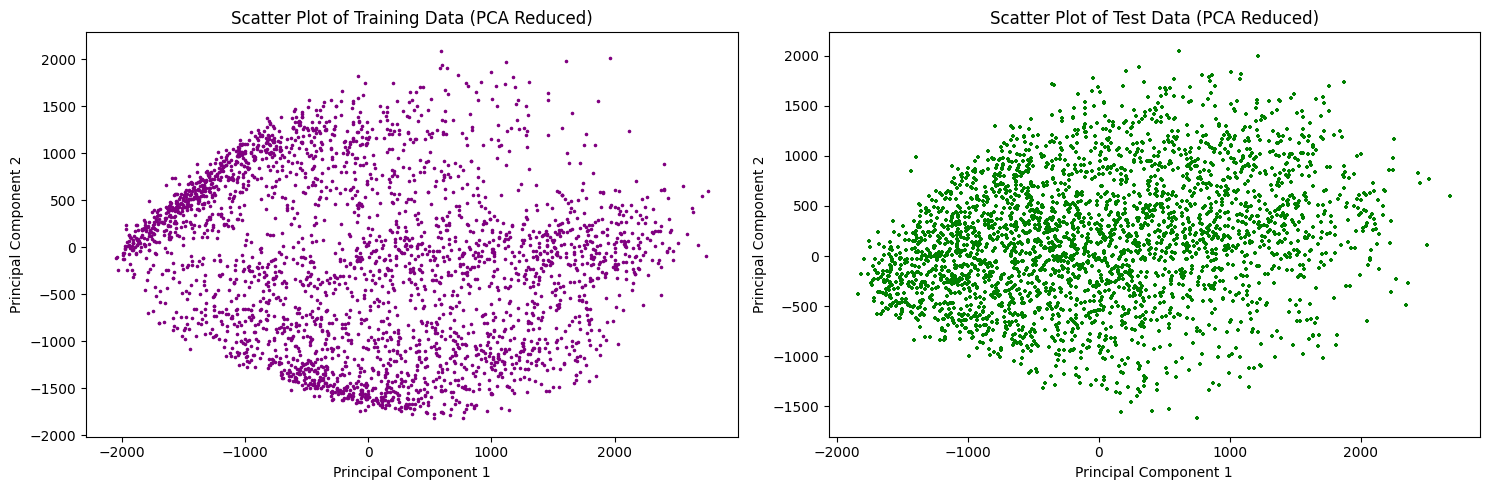

In [34]:
# Set the figure size
plt.figure(figsize=(15, 5))

# Plotting the training data on the left subplot
plt.subplot(1, 2, 1)
plt.scatter(Xtrain_reduced[:, 0], Xtrain_reduced[:, 1], c='purple', marker='.', s=10)
plt.title('Scatter Plot of Training Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plotting the test data on the right subplot
plt.subplot(1, 2, 2)
plt.scatter(Xtest_reduced[:, 0], Xtest_reduced[:, 1], c='green', marker='+', s=10)
plt.title('Scatter Plot of Test Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

The scatter plots of both the training and test data exhibit an oval shape, with their positions roughly overlapping and a tendency for denser points on the left and sparser points on the right. However, on the left side of the plot, the density of training data is concentrated along the boundary of the shape, whereas the test data is more concentrated within the interior of the shape. This observation indicates both similarities and certain distinctions in the distribution of training and test data.

### iii. PCA Screen Graph

*Plot the scree graph of PCA and find the number of dimensions that explain 95% variance in the training set.*

In [35]:
# Apply PCA
pca = PCA()
Xtrain_pca = pca.fit_transform(Xtrain)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

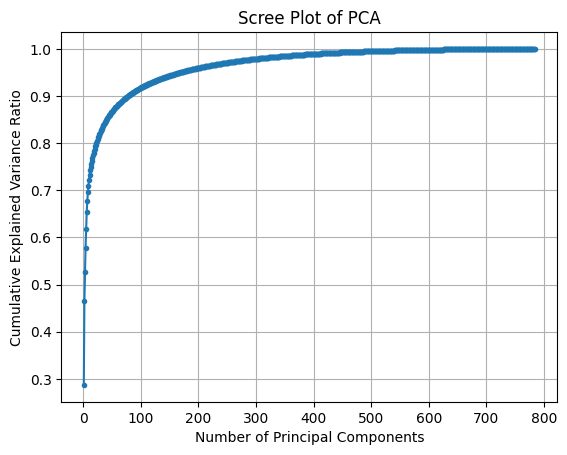

Number of dimensions for 95% variance: 168


In [36]:
# Plot the scree graph
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot of PCA')
plt.grid(True)
plt.show()

# Find the number of dimensions that explain 95% variance
num_dimensions_95_percent_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f'Number of dimensions for 95% variance: {num_dimensions_95_percent_variance}')

The number of dimensions that explain 95% variance in the training set is 168.

### iv. Classification

*Reduce the number of dimensions of the data using PCA and perform classification. You may want to select different principal components for the classification (not necessarily the first few). What is the (optimal) cross-validation performance of a Kernelized SVM classification with PCA? Remember to perform hyperparameter optimization!*

We may want to use the training data preprocessed with min-max scaling when it comes to classification. We pick the number of principal components from the range 100 to 400. Based on previous questions, we choose Radial Basis Function SVM.

In [7]:
num_dimensions = [100, 150, 200, 250, 300, 350, 400]

param_grid_rbf_svm =     {
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

for num_dimension in num_dimensions:
    pca = PCA(n_components=num_dimension)
    Xtrain_pca = pca.fit_transform(Xtrain_minmax)

    # Create the SVM classifier and perform grid search
    svm_search = grid_search(SVC(probability=True, kernel='rbf'), param_grid_rbf_svm, Xtrain_pca, Ytrain)
    # Print the best parameters
    print(f"For {num_dimension} components: ")
    print("- Best params:", svm_search.best_params_, "- MCC:", svm_search.best_score_)

For 100 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.597570389127874
For 150 components: 
- Best params: {'C': 1000, 'gamma': 0.01} - MCC: 0.6043619566859062
For 200 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.6043383366759032
For 250 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.6101601112112597
For 300 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.6103083769747336
For 350 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.6055499901637947
For 400 components: 
- Best params: {'C': 100, 'gamma': 0.01} - MCC: 0.6106509103265069


The results are roughly the same, nothing much interesting.

In [6]:
def average_metrics(classifier, X, Y):

    # Add a new function to calculate PR AUC
    def pr_auc_score(y_true, y_pred):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        return auc(recall, precision)
    
    metrics = {
        'Accuracy': accuracy_score,
        'Balanced Accuracy': balanced_accuracy_score,
        'ROC AUC': roc_auc_score,
        'PR AUC': pr_auc_score,
        'F1 Score': f1_score,
        'MCC': matthews_corrcoef
    }

    # Perform 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    metric_values_list = {metric_name: [] for metric_name in metrics}

    for train_index, test_index in skf.split(X, Y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]

        # Fit the classifier on the training data
        classifier.fit(X_train_fold, Y_train_fold)

        # Loop through each metric
        for metric_name, metric_func in metrics.items():
            # Make predictions on the test data
                predictions = classifier.predict(X_test_fold)
                probabilities = classifier.predict_proba(X_test_fold)[:, 1]

                # Calculate the metric for this fold
                if metric_name in ['ROC AUC', 'PR AUC']:
                    metric_value = metric_func(Y_test_fold, probabilities)
                else:
                    metric_value = metric_func(Y_test_fold, predictions)
                metric_values_list[metric_name].append(metric_value)
        
    # Print the average and standard deviation of the metrics across all folds
    for metric_name, metric_values in metric_values_list.items():
        average_value = np.mean(metric_values)
        std_dev_value = np.std(metric_values)
        print(f"Average {metric_name}: {average_value:.4f} (Std Dev: {std_dev_value:.4f})")

In [8]:
pca = PCA(n_components=300)
Xtrain_pca = pca.fit_transform(Xtrain_minmax)

average_metrics(SVC(probability=True, kernel='rbf', C=100, gamma=0.01), Xtrain_pca, Ytrain)

Average Accuracy: 0.9310 (Std Dev: 0.0103)
Average Balanced Accuracy: 0.7938 (Std Dev: 0.0252)
Average ROC AUC: 0.9295 (Std Dev: 0.0054)
Average PR AUC: 0.7114 (Std Dev: 0.0278)
Average F1 Score: 0.6513 (Std Dev: 0.0491)
Average MCC: 0.6142 (Std Dev: 0.0551)


With the number of dimensions reduced to 300, the (optimal) cross-validation performance of our Kernelized SVM classification with PCA is approximately the same as Kernelized SVM classification without PCA as shown in Question 3.

## Question No. 5: Optimal Pipeline

*Develop an optimal pipeline for classification based on your analysis (Q1-Q4). You are free to use any tools or approaches at your disposal. However, no external data sources may be used. Describe your pipeline and report your outputs over the test data set. (You are required to submit your prediction file together with the assignment in a zip folder). Your prediction file should be a single column file containing the prediction score of the corresponding example in Xtest (be sure to have the same order as the order of the test examples in Xtest!). Your prediction file should be named by your student ID, e.g., u100011.csv.*

- The final **OPTIMAL** pipeline will be described after and explained through Question 6.

## Question No. 6 Another classification problem

*Using the data given to you, consider an alternate classification problem in which the label of an example is based on whether it is a part of the training set (label = -1) or the test set (label = +1). Calculate the average and standard deviation of AUC-ROC using 5-fold stratified cross-validation for a classifier that is trained  to solve this prediction task.*

### i. AUC-ROC

*What does the value of this AUC-ROC tell you about any differences between training and test sets? Show code for this analysis and clearly explain your conclusions with supporting evidence.*

For this problem we aim to explore and understand the difference between training and test sets. So instead of looking for an optimal classifier we return to simply using the good old k = 5 nearest neighbour classifier.

In [9]:
test_classifier = KNeighborsClassifier(n_neighbors=5)

Ytrain_ = np.full(Xtrain.shape[0], -1)
Ytest_ = np.full(Xtest.shape[0], 1)

Xmerged = np.concatenate((Xtrain, Xtest), axis=0)
Ymerged = np.concatenate((Ytrain_, Ytest_), axis=0)

average_metrics(test_classifier, Xmerged, Ymerged)

Average Accuracy: 0.9230 (Std Dev: 0.0093)
Average Balanced Accuracy: 0.9230 (Std Dev: 0.0093)
Average ROC AUC: 0.9682 (Std Dev: 0.0042)
Average PR AUC: 0.9793 (Std Dev: 0.0021)
Average F1 Score: 0.9181 (Std Dev: 0.0106)
Average MCC: 0.8520 (Std Dev: 0.0168)


The AUC-ROC near 0.97 indicates that this simple, untuned model performs exceptionally well on this new classification task. We may further conclude that the differences between training and test sets is even greater than the differences between the two classes within the training dataset (our optimal AUC-ROC for which has been around 0.93). This discovery is quite disheartening, as it suggests that the classifier obtained on the training set is very unlikely to generalize well on the test set.

### ii. Systematic Difference

*How can you use this experiment to identify and eliminate any systematic differences between training and test sets?*

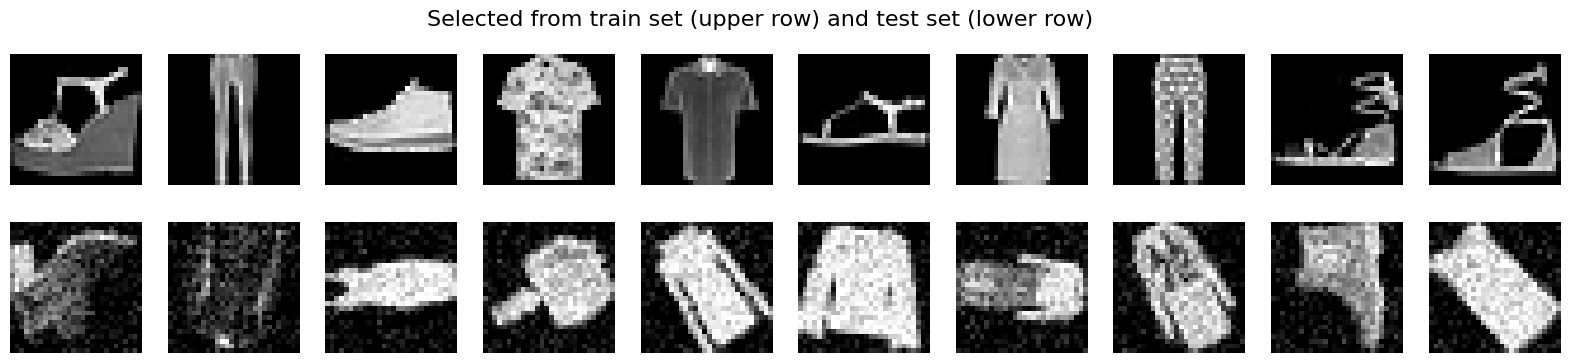

In [10]:
# Create a figure for plotting
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Select 10 random objects from each dataset
random_indices = np.random.choice(np.arange(3000), size=10, replace=False)
random_objects_train = Xtrain[random_indices]
random_objects_test = Xtest[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_train[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_test[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from train set (upper row) and test set (lower row)', fontsize=16)

plt.show()

When we visualized the images from the training and test dataset, the most significant difference between the two to human eye is that objects in the training set are all in the upright position, whereas in the test set, almost all objects are rotated at different angles. Due to the challenge of aligning the orientations of objects in the test set, we may consider applying random angle rotations to each image in the training set to eliminate systematic differences between the two datasets.

In [12]:
num_images, height, width = 3000, 28, 28
min_angle, max_angle = 0, 360

random_angles = np.random.uniform(low=min_angle, high=max_angle, size=num_images)

rotated_images = [ndimage.rotate(image.reshape((height, width)), angle, reshape=False) 
                  for image, angle in zip(Xtrain, random_angles)]

Xtrain_rotated = np.array(rotated_images).reshape(3000, 784)

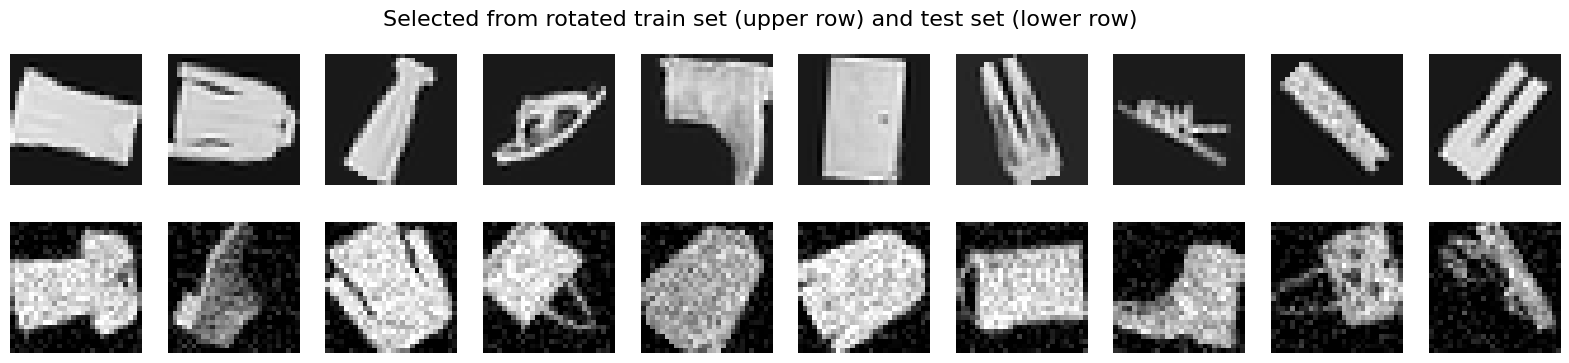

In [13]:
# Create a figure for plotting
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Select 10 random objects from each dataset
random_indices = np.random.choice(np.arange(3000), size=10, replace=False)
random_objects_train_rotated = Xtrain_rotated[random_indices]
random_objects_test = Xtest[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(10):
    axes[0, i].matshow(random_objects_train_rotated[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].matshow(random_objects_test[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

# Add a title to the entire figure
plt.suptitle('Selected from rotated train set (upper row) and test set (lower row)', fontsize=16)

plt.show()

After this rotation, randomly selected examples from the training and test dataset looks more similar.

In [14]:
Xmerged_rotated = np.concatenate((Xtrain_rotated, Xtest), axis=0)

average_metrics(test_classifier, Xmerged_rotated, Ymerged)

Average Accuracy: 0.5785 (Std Dev: 0.0091)
Average Balanced Accuracy: 0.5785 (Std Dev: 0.0091)
Average ROC AUC: 0.6076 (Std Dev: 0.0134)
Average PR AUC: 0.6009 (Std Dev: 0.0131)
Average F1 Score: 0.5391 (Std Dev: 0.0089)
Average MCC: 0.1597 (Std Dev: 0.0200)


We can see the new AUC-ROC becomes 0.6, which means the classifier's performance is still better than random guessing (the AUC-ROC for which should be around 0.5), but the classifier is much worse at telling the difference between the training and test dataset. This is encouraging, as we can tell the rotated training set now has a more similar distribution to the test set.

In [15]:
# Concatenate training and test data for joint PCA
X_combined = np.vstack((Xtrain_rotated, Xtest))

# Apply PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
X_combined_reduced = pca.fit_transform(X_combined)

# Separate the combined data back into training and test data
Xtrain_reduced = X_combined_reduced[:len(Xtrain)]
Xtest_reduced = X_combined_reduced[len(Xtrain):]

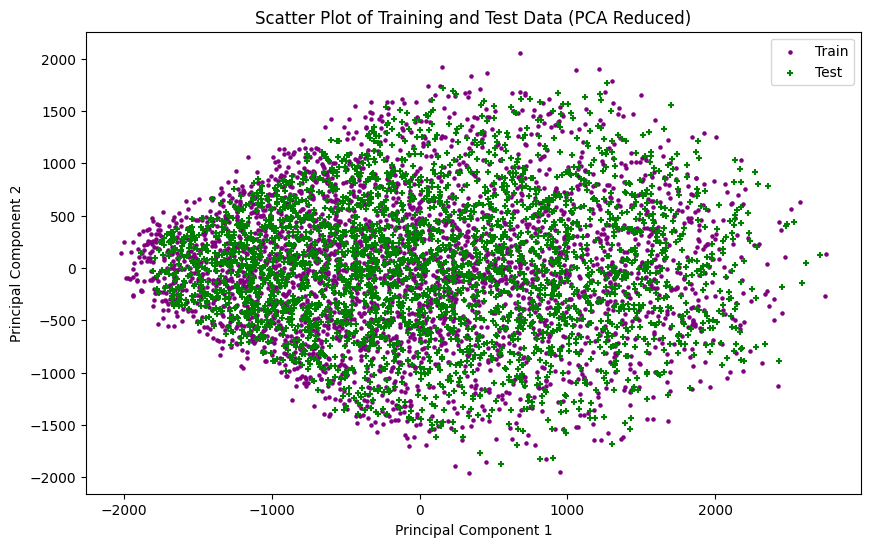

In [17]:
plt.figure(figsize=(10, 6))

# Create a scatter plot with different colors for training and test data
plt.scatter(Xtrain_reduced[:, 0], Xtrain_reduced[:, 1], \
    label='Train', c='purple', marker='.', s=20)
plt.scatter(Xtest_reduced[:, 0], Xtest_reduced[:, 1], \
    label='Test', c='green', marker='+', s=20)

# Add labels and a legend
plt.title('Scatter Plot of Training and Test Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

We reduce the number of dimensions of the rotated training and test data together to two again and plot a scatter plot. It can be seen from the plot that the two datasets now do have more similar distributions than before rotating.

Now let us do some grid search again to find the best classifier on rotated training data.

In [18]:
Xtrain_rotated_minmax = minmax.fit_transform(Xtrain_rotated)

In [26]:
# Create the SVM classifier and perform grid search
svm_r = grid_search(SVC(probability=True), param_grid_svm, Xtrain_rotated_minmax, Ytrain)

# Print the best parameters
print("Best Parameters", svm_r.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", svm_r.best_score_)

Best Parameters {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best MCC score: 0.2953294415064862


In [29]:
relevant_info = sorted_score(svm_r)

# Print the sorted information
for info in relevant_info[5]:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}         Mean: 0.2953          Std: 0.0495
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}        Mean: 0.2953          Std: 0.0495
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.2866          Std: 0.0400
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.2830          Std: 0.0470
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.2783          Std: 0.0554
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.2673          Std: 0.0442
{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.2661          Std: 0.0505
{'C': 1000, 'degree': 5, 'kernel': 'poly'}         Mean: 0.2658          Std: 0.0282
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.2639          Std: 0.0522
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}          Mean: 0.2573          Std: 0.0500
{'C': 100, 'degree': 5, 'kernel': 'poly'}          Mean: 0.2465          Std: 0.0485
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}       Mean: 0.2440  

In [28]:
# Create the KNN classifier and perform grid search
knn_r = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain_rotated_minmax, Ytrain)

# Print the best parameters
print("Best Parameters", knn_r.best_params_)

# Print the best cross-validated MCC
print("Best MCC score:", knn_r.best_score_)

Best Parameters {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best MCC score: 0.20050358328427


In [32]:
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=9, p=1, weights='distance'),
    'Poly SVM': SVC(probability=True, C=1000, degree=4, kernel='poly'),
    'RBF SVM': SVC(probability=True, C=100, gamma=0.01, kernel='rbf')
}

compare_classifiers(classifiers, Xtrain_rotated_minmax, Ytrain)

Classifier     Accuracy       Balanced       AUC-ROC        AUC-PR         F1 Score       MCC            
KNN            0.8847         0.5532         0.7945         0.3015         0.1945         0.1661         
Poly SVM       0.8527         0.6379         0.7085         0.2670         0.3383         0.2579         
RBF SVM        0.8833         0.6421         0.8200         0.3475         0.3716         0.3126         


The classification performance on the rotated training set is much worse. It might be better if we could calibrate the images in the test set instead of rotating the images in the training set to achieve alignment between the two datasets. Unfortunately, at this stage, I don't have the means to do so. We can try evaluating both methods separately on the test set.

In [39]:
the_chosen_one = SVC(probability=True, C=100, gamma=0.01, kernel='rbf')

the_chosen_one.fit(Xtrain_minmax, Ytrain)

Ytest_minmax = the_chosen_one.predict(Xtest_minmax)

In [40]:
# Count positive examples
test_positive = np.sum(Ytest_minmax == 1)

# Count negative examples
test_negative = np.sum(Ytest_minmax == -1)

print("Number examples in the test data labeled as positive :", test_positive)
print("Number examples in the test data labeled as negative :", test_negative)

Number examples in the test data labeled as positive : 322
Number examples in the test data labeled as negative : 2678


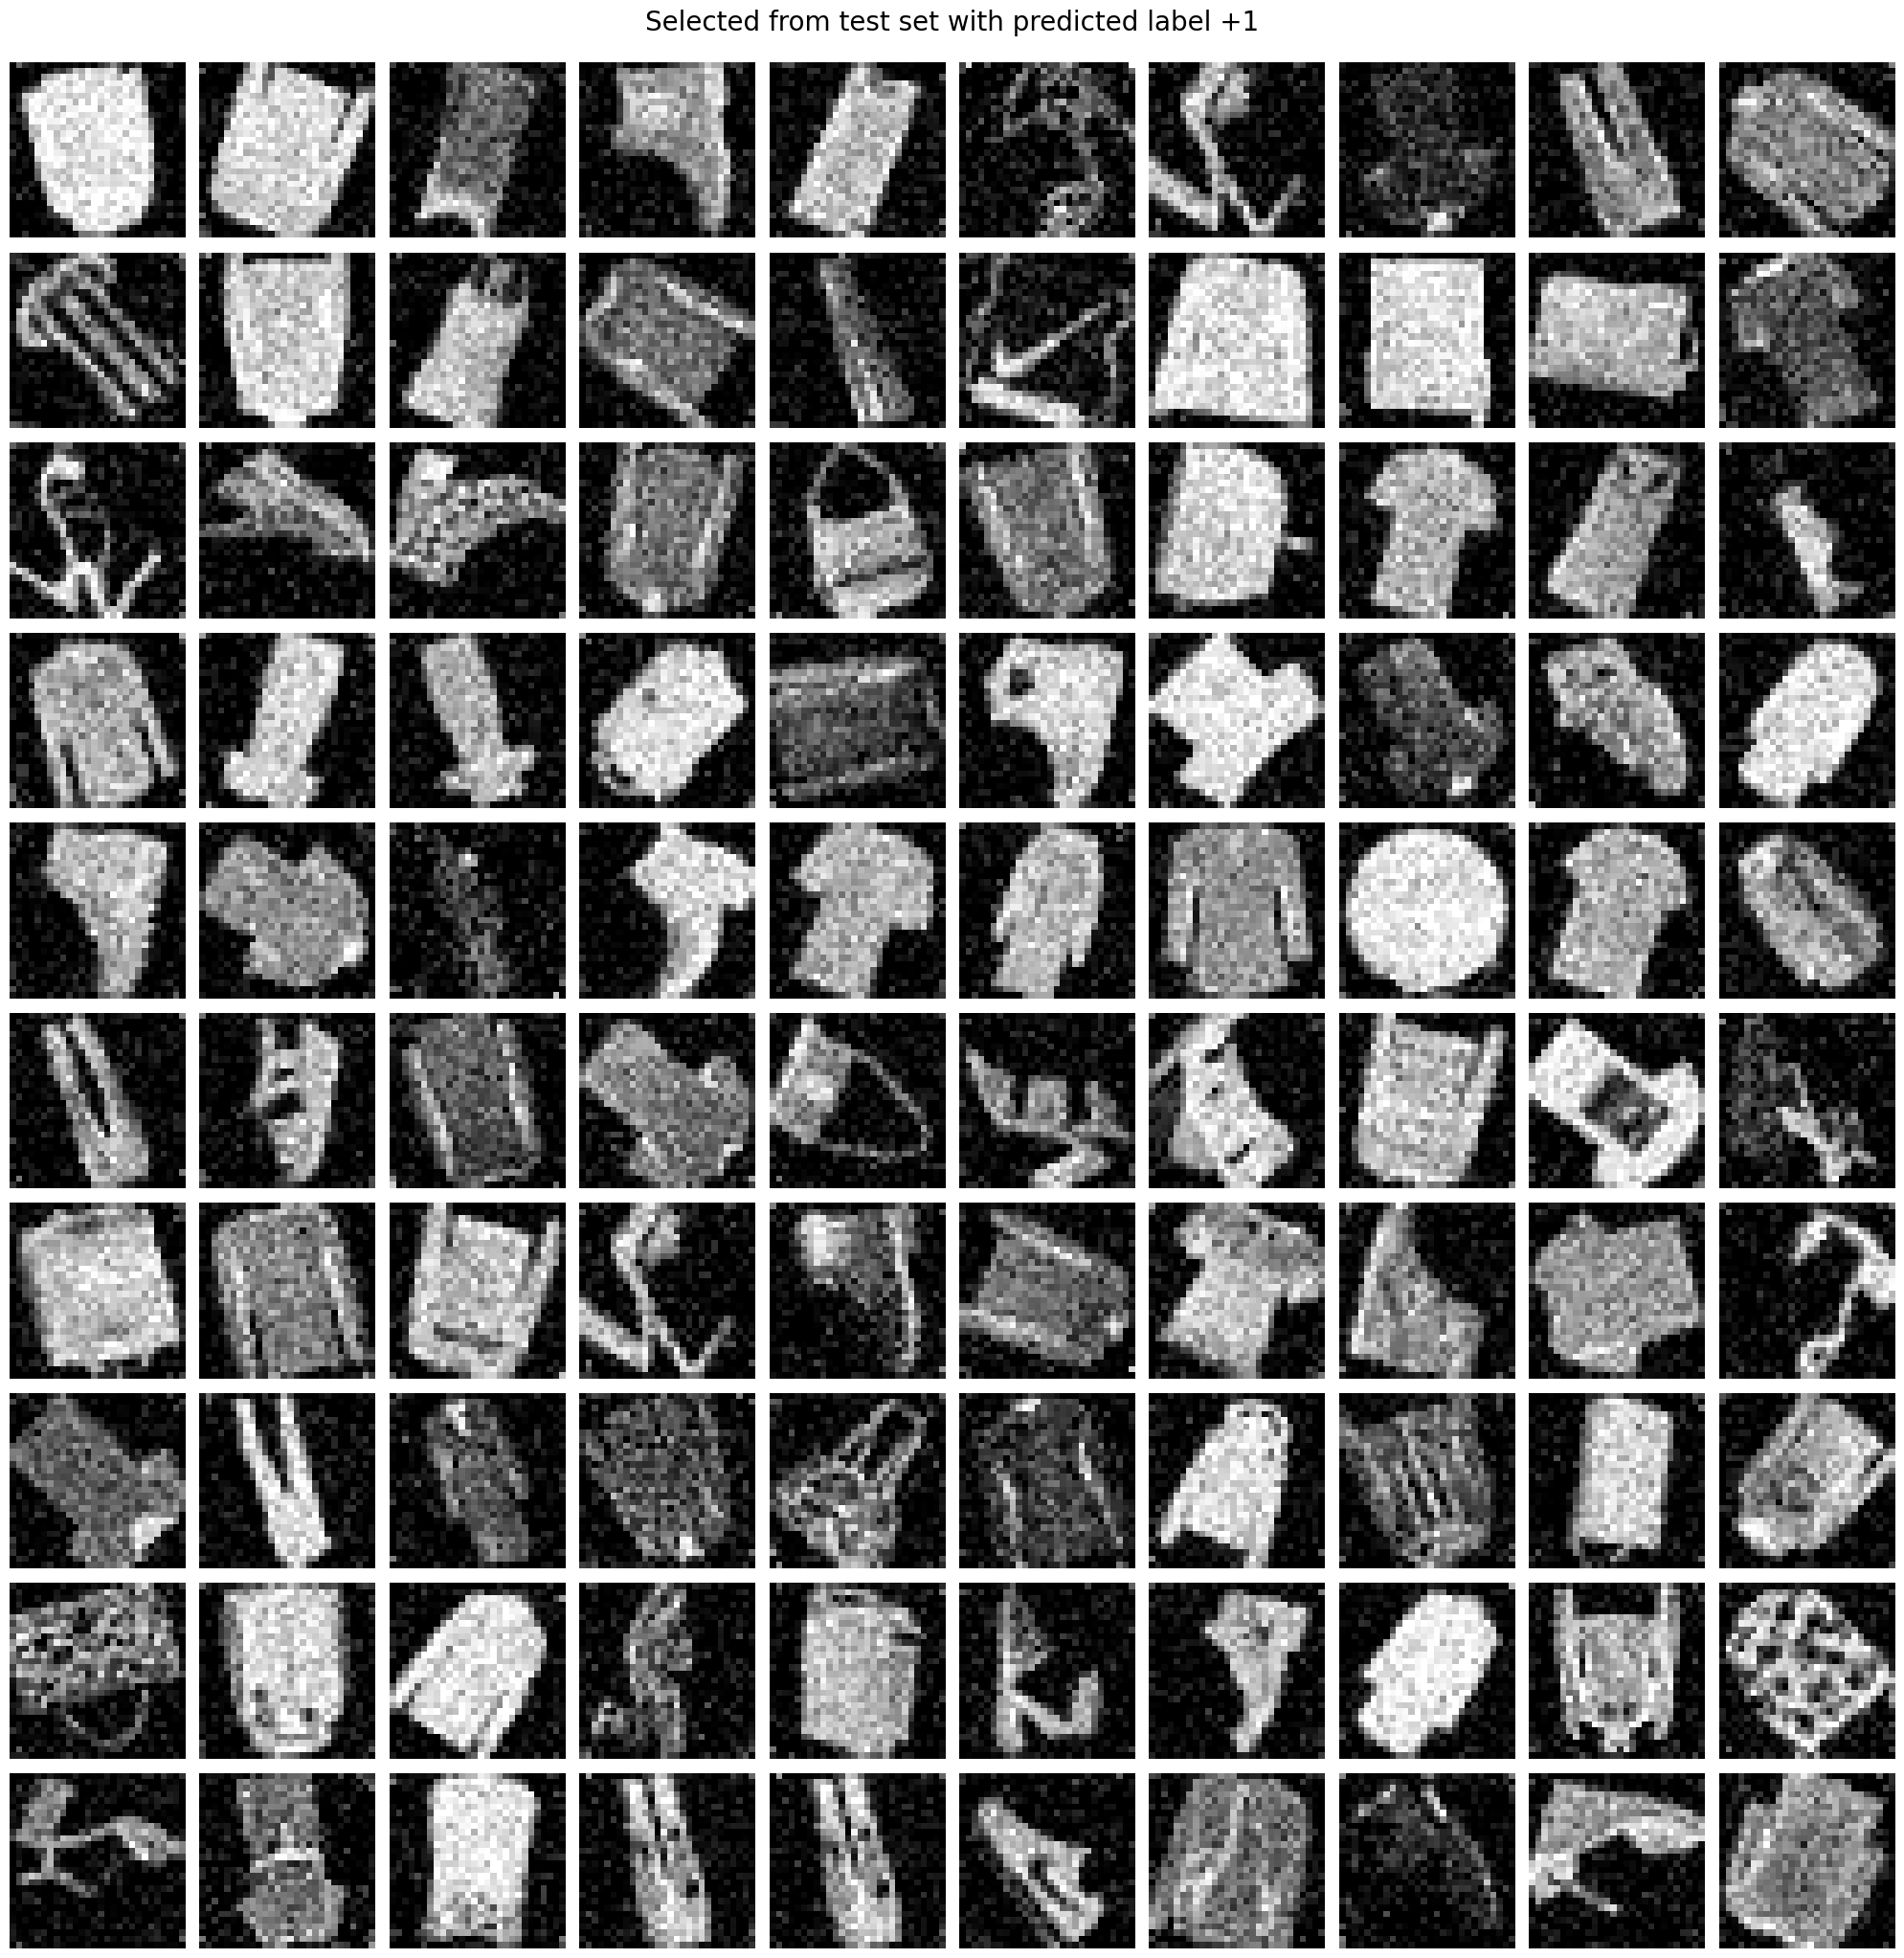

In [46]:
# Create a figure for plotting
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Select 100 random objects from test examples labeled as positive
class_indices = np.where(Ytest_minmax == 1)[0]
random_indices = np.random.choice(class_indices, size=100, replace=False)
random_objects = Xtest_minmax[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(100):
    axes[i // 10, i % 10].matshow(random_objects[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].axis('off')

# Add a title to the entire figure
plt.tight_layout()
plt.suptitle('Selected from test set with predicted label +1', fontsize=20, y=1.02)

plt.show()

In [42]:
the_chosen_one.fit(Xtrain_rotated_minmax, Ytrain)

Ytest_rotated_minmax = the_chosen_one.predict(Xtest_minmax)

In [43]:
# Count positive examples
test_positive = np.sum(Ytest_rotated_minmax == 1)

# Count negative examples
test_negative = np.sum(Ytest_rotated_minmax == -1)

print("Number examples in the test data labeled as positive :", test_positive)
print("Number examples in the test data labeled as negative :", test_negative)

Number examples in the test data labeled as positive : 123
Number examples in the test data labeled as negative : 2877


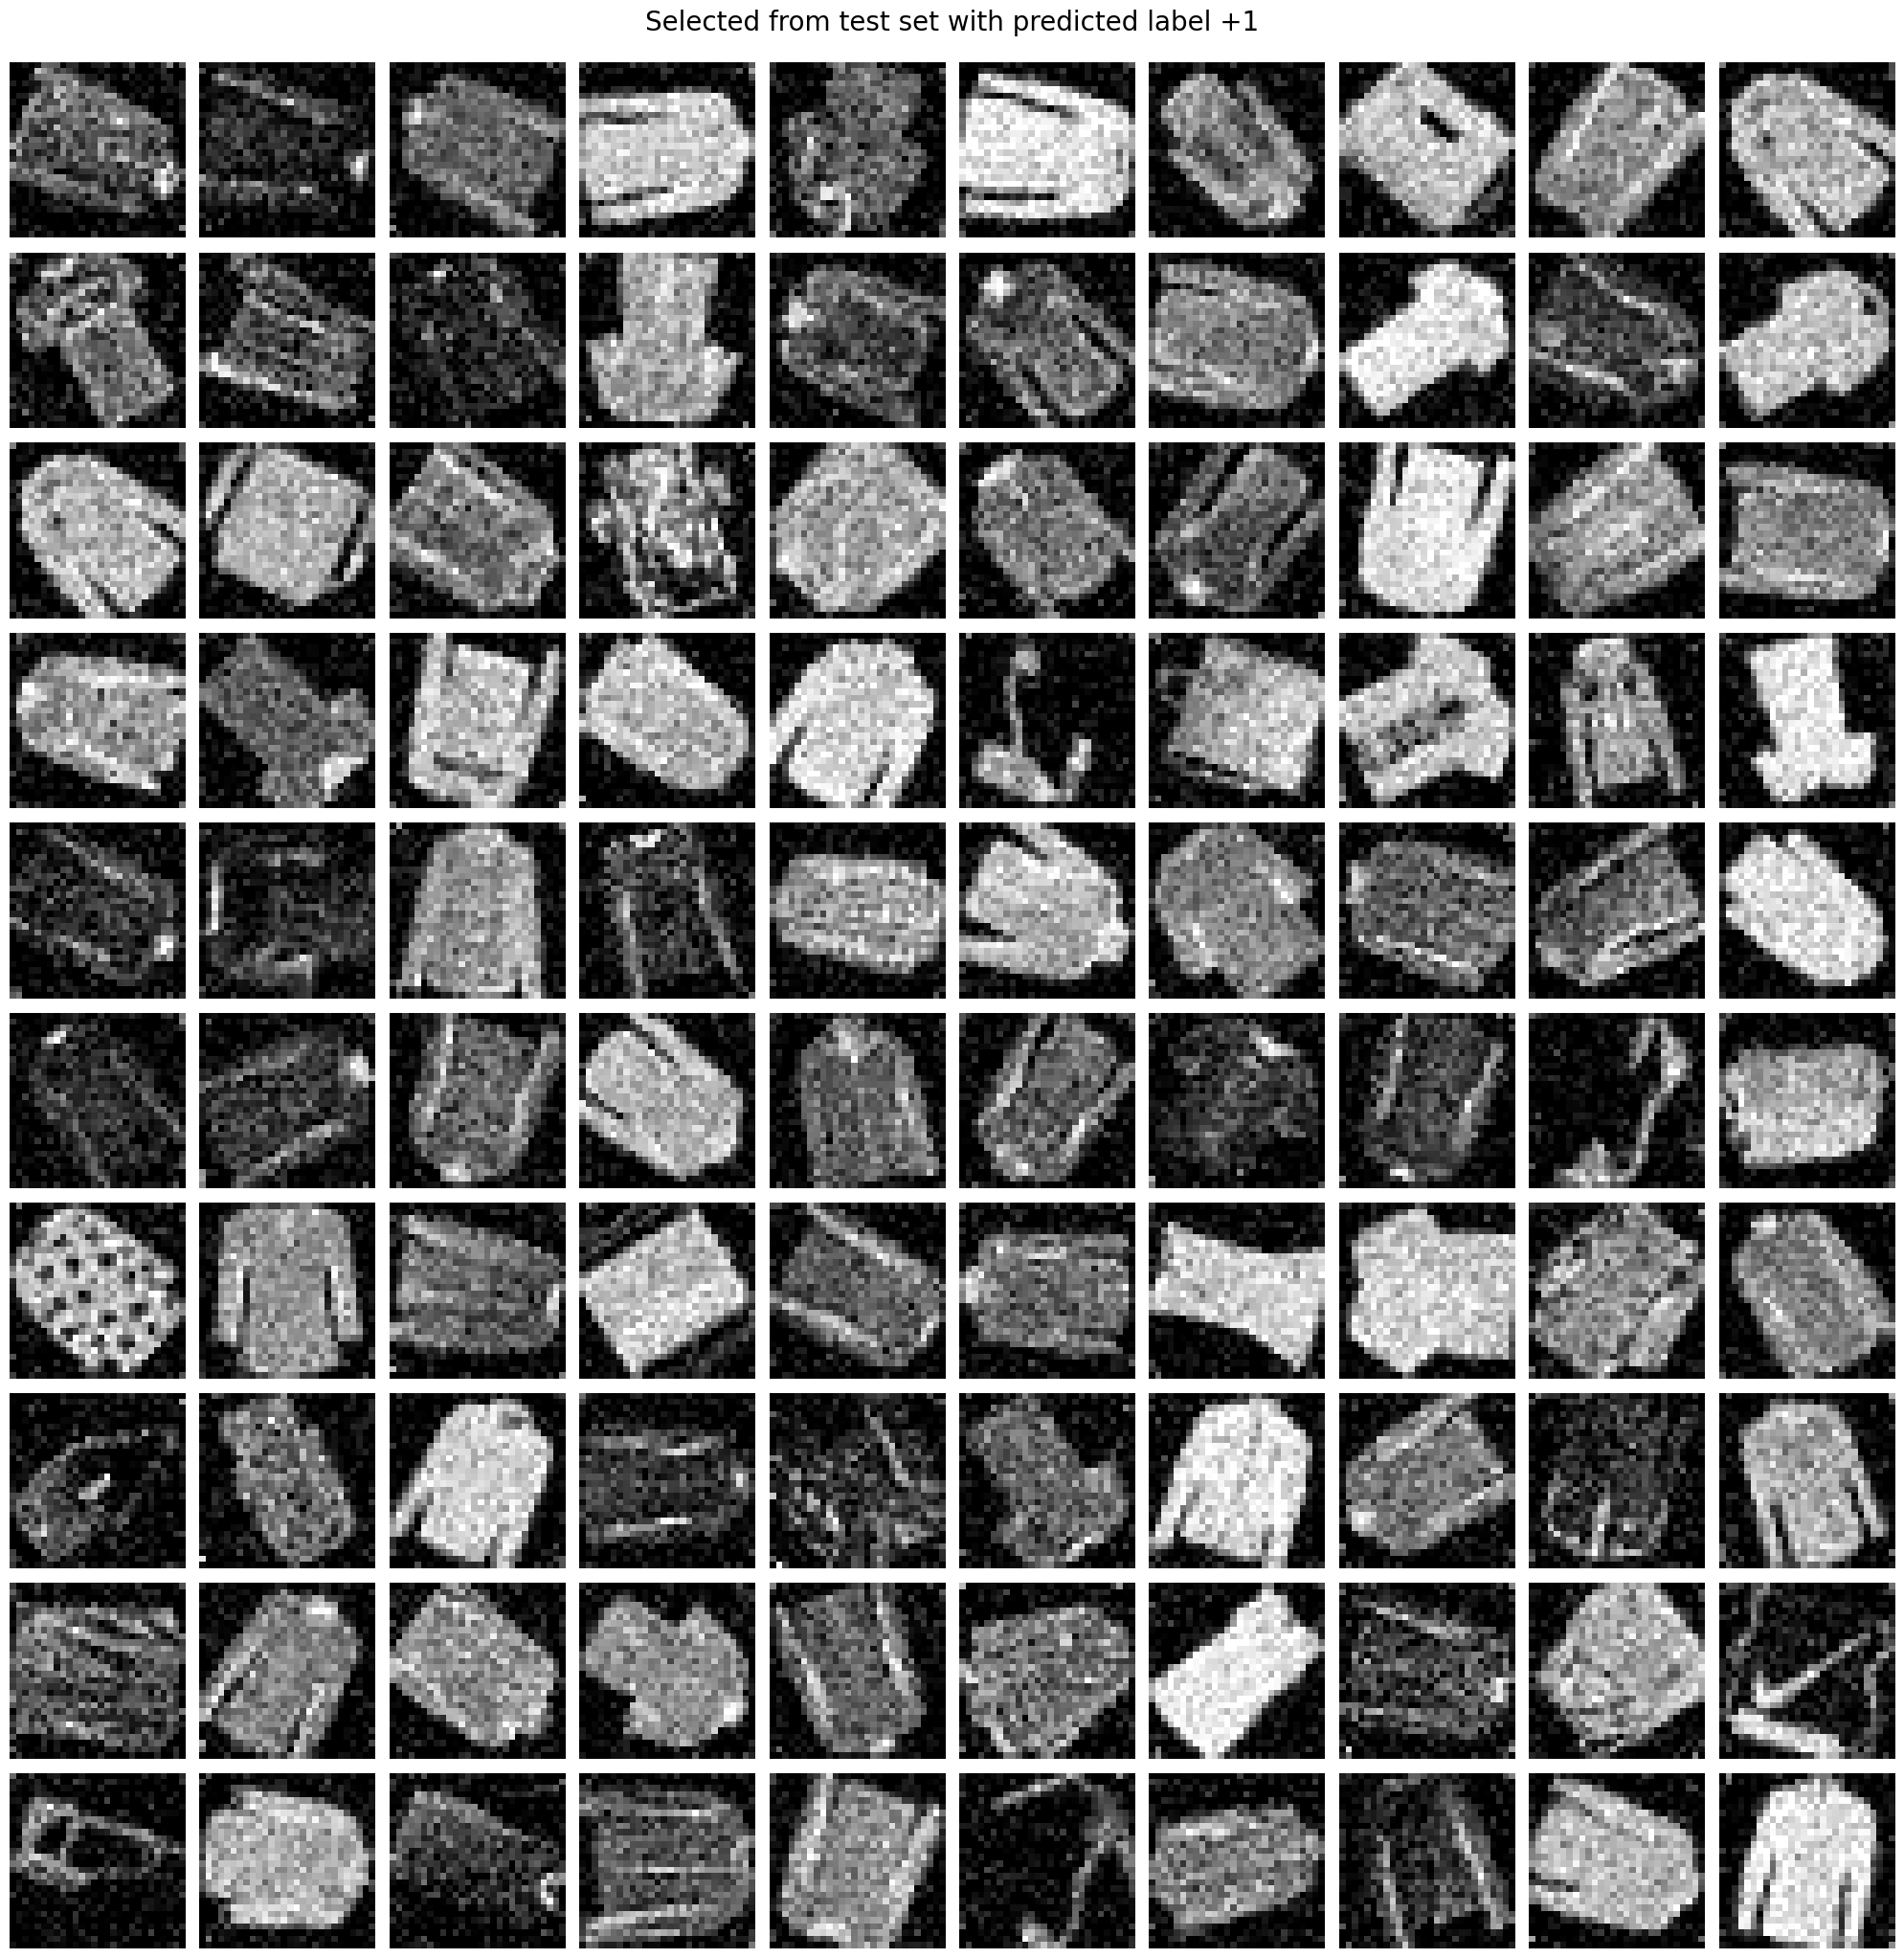

In [45]:
# Create a figure for plotting
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Select 100 random objects from test examples labeled as positive
class_indices = np.where(Ytest_rotated_minmax == 1)[0]
random_indices = np.random.choice(class_indices, size=100, replace=False)
random_objects = Xtest_minmax[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(100):
    axes[i // 10, i % 10].matshow(random_objects[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].axis('off')

# Add a title to the entire figure
plt.tight_layout()
plt.suptitle('Selected from test set with predicted label +1', fontsize=20, y=1.02)

plt.show()

From the images labeled as +1, it seems that rotating the training set has some benefits: almost all images labeled as +1 by the classifier trained on the rotated training set are indeed upper garments, whereas in the classifier trained on the original dataset, images labeled as +1 include many trousers, shoes, and bags. However, the latter classifier only labels about 1/30 of the test points as +1. Considering that the ratio of +1 in the training set is approximately 1/10, if we assume that the labels have a similar distribution in the training and test sets, then this proportion would seem inappropriate.

Another way is to put the rotated images together with the original ones for training.

In [56]:
Xtrain_concatenate = minmax.fit_transform(np.concatenate((Xtrain_minmax, Xtrain_rotated_minmax), axis=0))
Ytrain_concatenate = np.concatenate((Ytrain, Ytrain), axis=0)

In [57]:
average_metrics(the_chosen_one, Xtrain_concatenate, Ytrain_concatenate)

Average Accuracy: 0.9057 (Std Dev: 0.0091)
Average Balanced Accuracy: 0.7077 (Std Dev: 0.0176)
Average ROC AUC: 0.8749 (Std Dev: 0.0069)
Average PR AUC: 0.5439 (Std Dev: 0.0359)
Average F1 Score: 0.5020 (Std Dev: 0.0342)
Average MCC: 0.4543 (Std Dev: 0.0392)


The performances on training data has improved (still worse than original but better than all rotated).

In [58]:
the_chosen_one.fit(Xtrain_concatenate, Ytrain_concatenate)

Ytest_concatenate = the_chosen_one.predict(Xtest_minmax)

In [59]:
# Count positive examples
test_positive = np.sum(Ytest_concatenate == 1)

# Count negative examples
test_negative = np.sum(Ytest_concatenate == -1)

print("Number examples in the test data labeled as positive :", test_positive)
print("Number examples in the test data labeled as negative :", test_negative)

Number examples in the test data labeled as positive : 188
Number examples in the test data labeled as negative : 2812


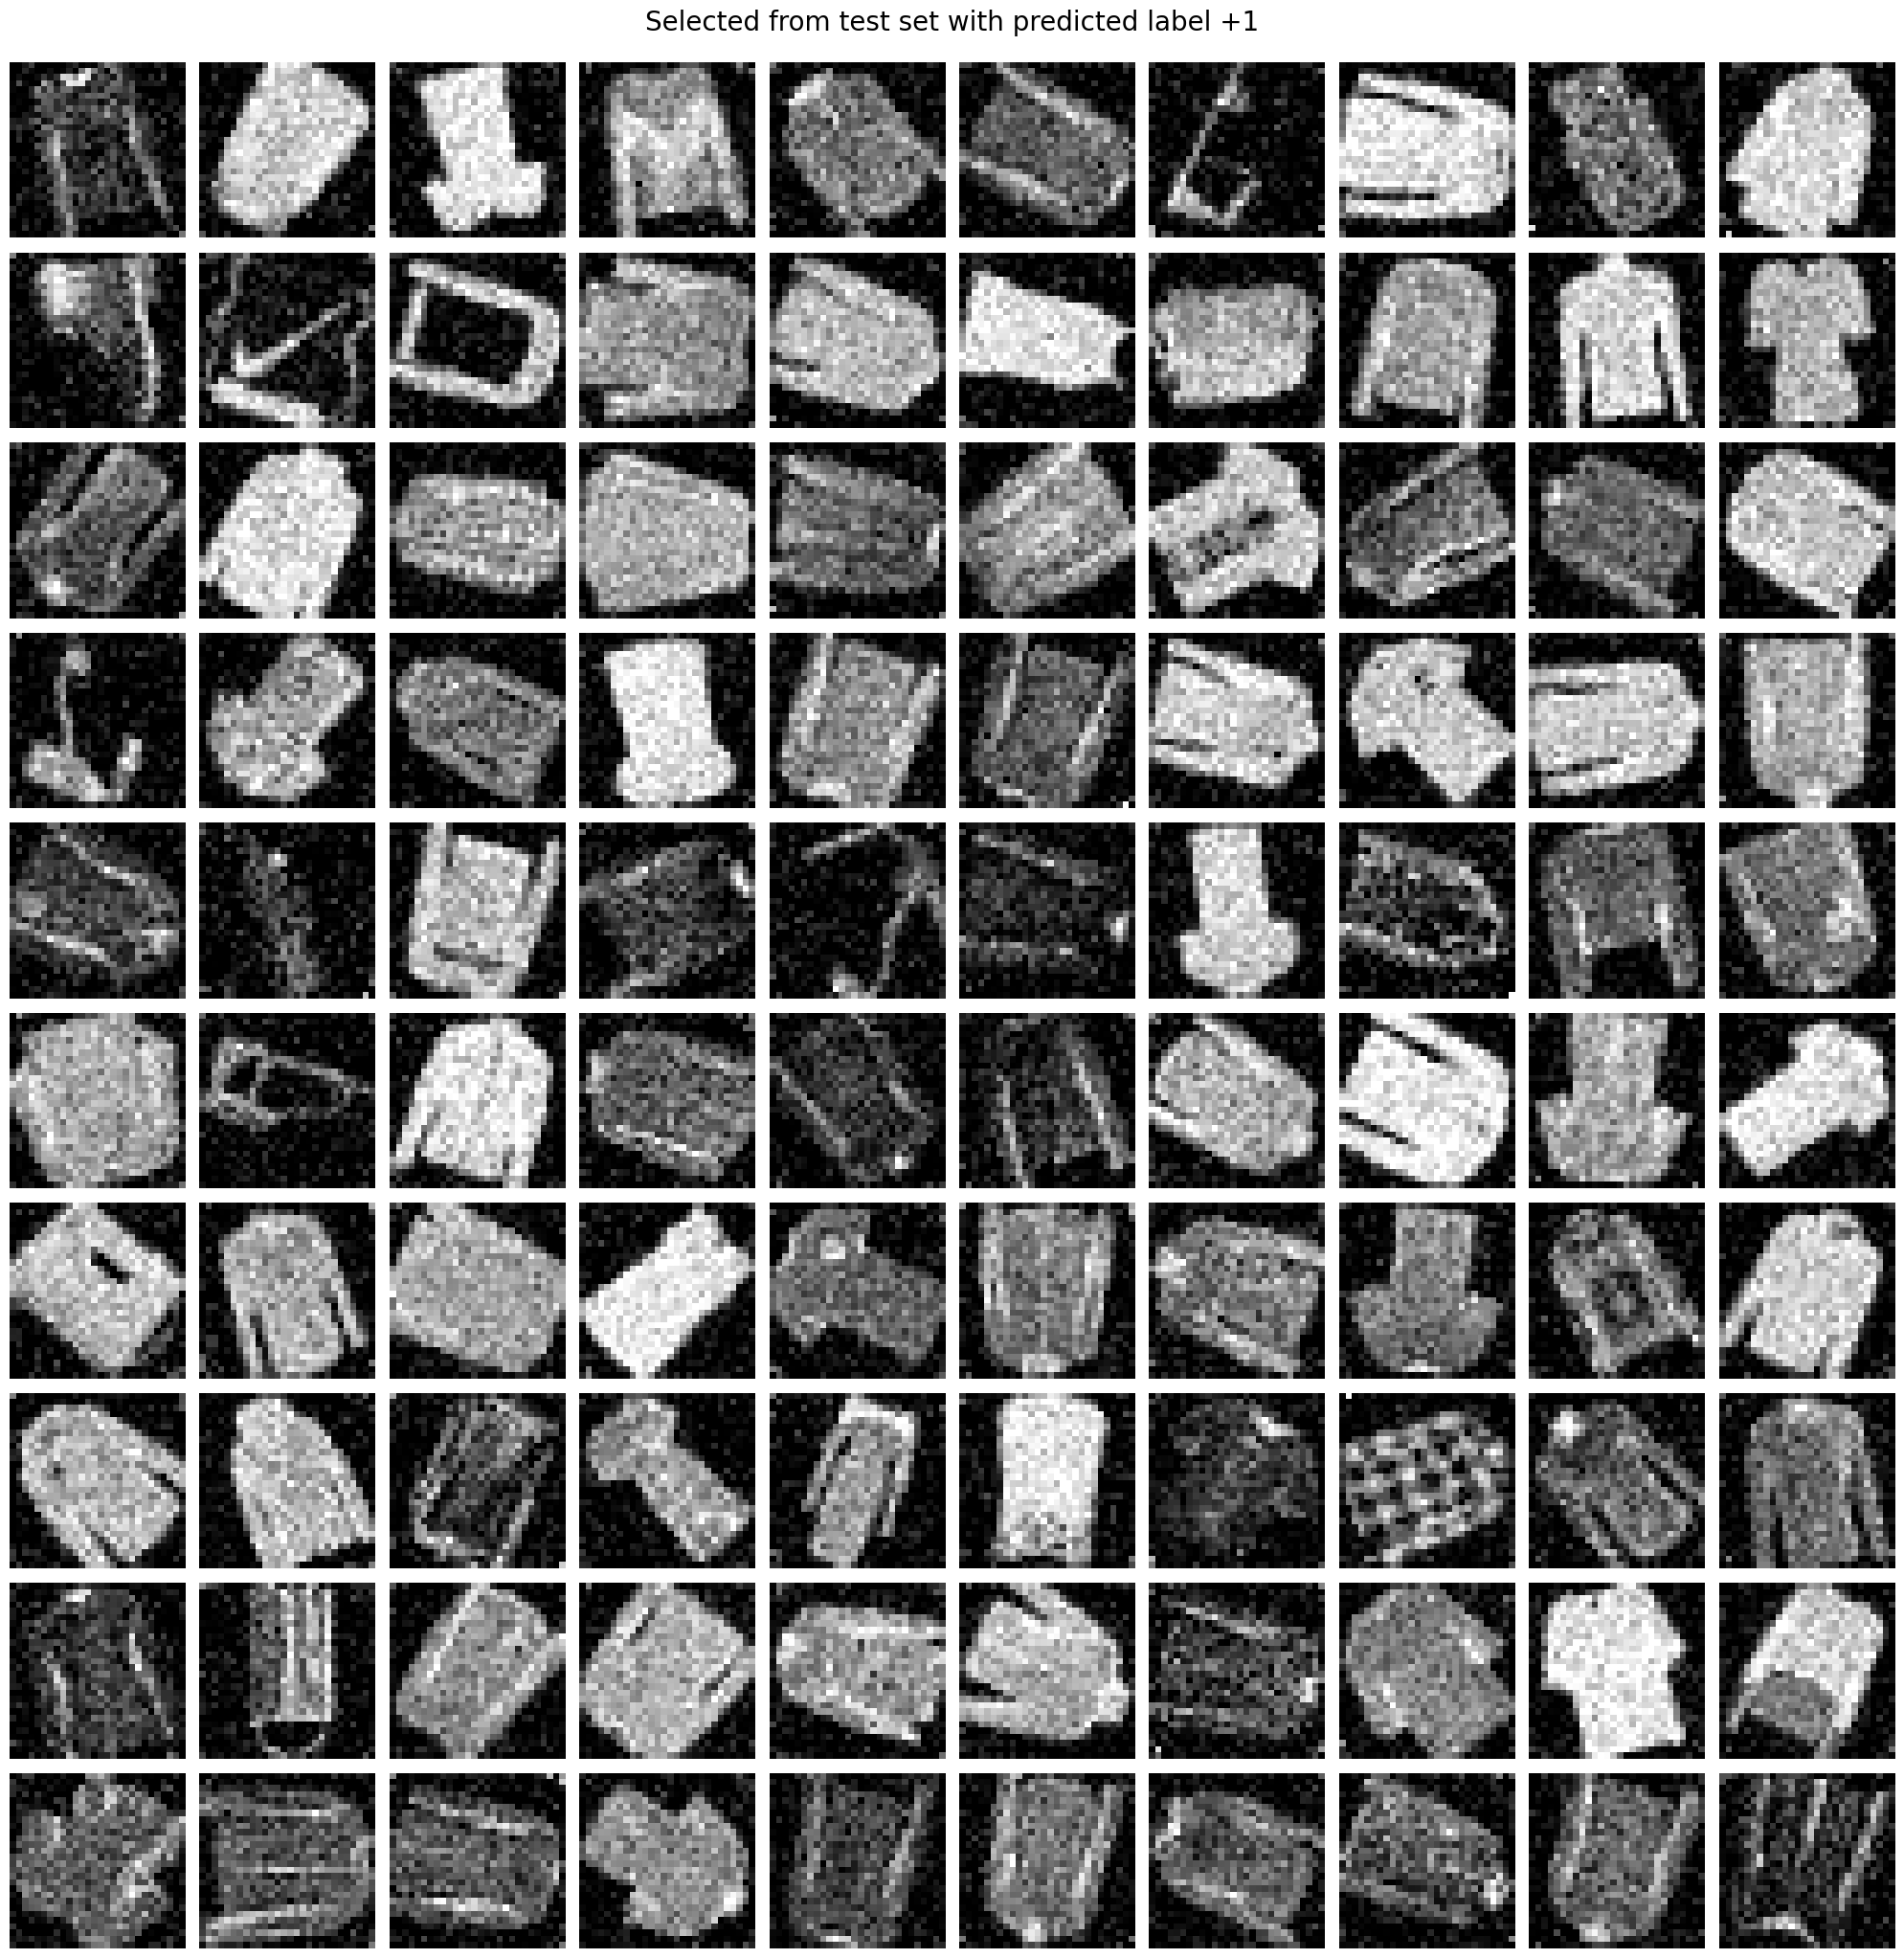

In [60]:
# Create a figure for plotting
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Select 100 random objects from test examples labeled as positive
class_indices = np.where(Ytest_concatenate == 1)[0]
random_indices = np.random.choice(class_indices, size=100, replace=False)
random_objects = Xtest_minmax[random_indices]

# Reshape and display the flattened 28x28 arrays
for i in range(100):
    axes[i // 10, i % 10].matshow(random_objects[i].reshape(28, 28), cmap='gray')
    axes[i // 10, i % 10].axis('off')

# Add a title to the entire figure
plt.tight_layout()
plt.suptitle('Selected from test set with predicted label +1', fontsize=20, y=1.02)

plt.show()

We now have more test examples labeled as +1, and they are mostly upper garments.

- So eventually our optimal pipeline is:

1. Rotate all images in the training set at random angles.
2. Merge the original training set with the rotated images.
3. Perform min-max scaling on both the training and test sets.
4. Train and predict using a Radial Basis Function SVM classifier with parameters C=100 and gamma=0.01.

In [62]:
with open('u5525549.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for value in Ytest_concatenate:
        writer.writerow([int(value)])